# PROJEKT MODELU REGRESYJNEGO PRZEWIDYWANIA CEN MIESZKAŃ NA PODSTAWIE #

# ALGORYTMU LGBM #

  ## KWIECIEŃ 2025 ##

In [1]:
import pandas as pd
import mlflow
# from pycaret.datasets import get_data 
from pycaret.regression import setup, pull, compare_models, plot_model, load_model, tune_model, finalize_model, save_model, predict_model, get_config
import pymysql
from sqlalchemy import create_engine
import numpy as np
# from scipy.stats import skewnorm 
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfVectorizer
# from joblib import parallel_backend 

In [2]:
MLFLOW_EXPERIMENT_NAME = 'Investoro_Ceny'
MLFLOW_TAGS = {'data': 'Investoro_ceny', 'library': 'pycaret'}

mlflow.set_tracking_uri("http://localhost:5000")

In [3]:
# tę komórkę uruchom jeśli czerpiesz dane z pliku .csv
df_original  = pd.read_csv('sale_2024_0.csv', sep=',')

In [4]:
df_original 

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,88,NaN,14,Mieszkanie trzypokojowe na sprzedaż,Mieszkanie o powierzchni 73m2 znajduje się na ...,73.00,766500.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,NaN,02TgImo1wm-Ra4zUQxoPBw==
1,99,NaN,19,Sprzedam mieszkanie na parterze 64.8m2 Białyst...,Sprzedam mieszkanie na parterze 64.8m2 w 3-pię...,64.80,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Antoniuk",20.0,61.0,1.0,1.0,922426.0,NaN,NaN,D-NUdVbtN3_kIW7ExgXkvA==
2,115,NaN,3,"Mieszkanie bezczynszowe, 3 pokoje, 2 łazienki",SPRZEDAŻ WYŁĄCZNIE BEZPOŚREDNIA. Agencjom nier...,51.00,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bagnówka",20.0,61.0,1.0,1.0,922461.0,NaN,NaN,lmBSU1XiXLSLOq1yKSe2kA==
3,140,NaN,14,Mieszkanie trzypokojowe na sprzedaż,***Oferta bez prowizji biura i podatku PCC!***...,67.62,544000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Józefa Karola Puchal...",20.0,61.0,1.0,1.0,922410.0,NaN,43141.0,HWachf5gb6Vq-sFYH4YWnA==
4,145,NaN,3,3 Pokoje- 48M2-Osiedle Dziesięciny,Przedstawiamy na sprzedaż 3 pokojowe mieszkani...,48.00,459000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Dziesięciny",20.0,61.0,1.0,1.0,922410.0,NaN,4656.0,AWsmt4ZY0X7lNv-6fSCn9Q==
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133882,4418401,NaN,2,Mieszkanie na sprzedaż - 59 m² - 3 pokoje Grod...,Poznaj naszą inwestycję NA WSPÓLNEJ zlokalizow...,59.99,NaN,NaN,NaN,NaN,...,NaN,"Mazowieckie, Grodziski, Grodzisk Mazowiecki, W...",14.0,5.0,4.0,5.0,2594.0,NaN,24885.0,Ogpi4Jwj8KWDyT0rM_vFYftiMRU9ErLfA6XOKdBw9jY=
1133883,4418402,NaN,2,Mieszkanie na sprzedaż - 41 m² - 2 pokoje Grod...,Poznaj naszą inwestycję NA WSPÓLNEJ zlokalizow...,41.23,NaN,NaN,NaN,NaN,...,NaN,"Mazowieckie, Grodziski, Grodzisk Mazowiecki, W...",14.0,5.0,4.0,5.0,2594.0,NaN,24885.0,Ogpi4Jwj8KWDyT0rM_vFYa7D8z7yjun2jGP_aZIReN8=
1133884,4418404,NaN,2,Mieszkanie na sprzedaż - 49 m² - 3 pokoje Grod...,Poznaj naszą inwestycję NA WSPÓLNEJ zlokalizow...,49.09,NaN,NaN,NaN,NaN,...,NaN,"Mazowieckie, Grodziski, Grodzisk Mazowiecki, W...",14.0,5.0,4.0,5.0,2594.0,NaN,24885.0,Ogpi4Jwj8KWDyT0rM_vFYf9eM73_U8S05NBjfLiez6E=
1133885,4418405,NaN,2,Mieszkanie na sprzedaż - 49 m² - 3 pokoje Grod...,Poznaj naszą inwestycję NA WSPÓLNEJ zlokalizow...,49.48,NaN,NaN,NaN,NaN,...,NaN,"Mazowieckie, Grodziski, Grodzisk Mazowiecki, W...",14.0,5.0,4.0,5.0,2594.0,NaN,24885.0,Ogpi4Jwj8KWDyT0rM_vFYRXVZdKE7iJxxFPu0Bq0ikc=


In [5]:
df_original .head(10)

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,88,NaN,14,Mieszkanie trzypokojowe na sprzedaż,Mieszkanie o powierzchni 73m2 znajduje się na ...,73.00,766500.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,NaN,02TgImo1wm-Ra4zUQxoPBw==
1,99,NaN,19,Sprzedam mieszkanie na parterze 64.8m2 Białyst...,Sprzedam mieszkanie na parterze 64.8m2 w 3-pię...,64.80,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Antoniuk",20.0,61.0,1.0,1.0,922426.0,NaN,NaN,D-NUdVbtN3_kIW7ExgXkvA==
2,115,NaN,3,"Mieszkanie bezczynszowe, 3 pokoje, 2 łazienki",SPRZEDAŻ WYŁĄCZNIE BEZPOŚREDNIA. Agencjom nier...,51.00,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bagnówka",20.0,61.0,1.0,1.0,922461.0,NaN,NaN,lmBSU1XiXLSLOq1yKSe2kA==
3,140,NaN,14,Mieszkanie trzypokojowe na sprzedaż,***Oferta bez prowizji biura i podatku PCC!***...,67.62,544000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Józefa Karola Puchal...",20.0,61.0,1.0,1.0,922410.0,NaN,43141.0,HWachf5gb6Vq-sFYH4YWnA==
4,145,NaN,3,3 Pokoje- 48M2-Osiedle Dziesięciny,Przedstawiamy na sprzedaż 3 pokojowe mieszkani...,48.00,459000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Dziesięciny",20.0,61.0,1.0,1.0,922410.0,NaN,4656.0,AWsmt4ZY0X7lNv-6fSCn9Q==
5,159,NaN,3,"Mieszkanie, 87 m², Białystok","Przestronne, jasne mieszkanie na zamkniętym os...",87.00,779000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Adama Mickiewicza",20.0,61.0,1.0,1.0,922410.0,NaN,12740.0,SEPz6jrRB1vuWWYOn99h7g==
6,165,NaN,3,Przytulne mieszkanie blisko centrum!,Na sprzedaż 2 pokojowe mieszkanie położone na ...,34.10,359000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,16041.0,Gt5-LUpJNg-wBgBd8-hxGQ==
7,173,NaN,3,"**Jasne, 2 Pokojowe Mieszkanie, Widok Na Miasto**","Mieszkanie o powierzchni 35,7 m2 Ul. Jarzębino...",35.70,380000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok",20.0,61.0,1.0,1.0,922410.0,NaN,7290.0,a5iP5JQyibefTTLgBRU8oA==
8,179,NaN,3,*Bezpośrednio*PIĘKNY APARTAMENT w Centrum Lipo...,***REZERWACJA ***WYJĄTKOWA PROPOZYCJA DLA WYMA...,39.40,559000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Adama Mickiewicza",20.0,61.0,1.0,1.0,922410.0,NaN,12740.0,C_F7Bxl4hKQ2a2votBqs-g==
9,189,NaN,4,2-pokojowe mieszkanie na sprzedaż,Na sprzedaż 2 pokojowe mieszkanie położone na ...,34.20,354000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Piasta",20.0,61.0,1.0,1.0,922410.0,NaN,16041.0,XylelQthYlIn_7k8orxBfQ==


In [6]:
df_original .sample(10)

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
762649,3524400,NaN,3,15 137/M2 | 2014R | Cisza I Spokój | 3 Pokoje,Opiekun oferty Mikołaj Kuśmierz tel. Skontaktu...,62.69,949000.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Praga-południe, Ul. Liw...",14.0,65.0,7.0,8.0,918838.0,NaN,11232.0,51A9DdU-RXsCFO1KHcy37FcgSx7sGm5nUpo5FzVSNNM=
577342,3048676,NaN,3,Komfortowe 4 pokoje w atrakcyjnej cenie,"Przestronne, czteropokojowe mieszkanie znajduj...",62.00,419000.0,NaN,NaN,429000.0,...,NaN,"Lubelskie, Lublin, Ul. Krańcowa",6.0,63.0,1.0,1.0,954700.0,NaN,9819.0,XY3-ZYiFtwX3vJeotOysSGjzzGldvCsejqBZGAbYChc=
807034,3650496,NaN,3,Ma sprzedaż trzech pokojowe mieszkanie,Mieszkanie trzechpokojowe na ul. Złota na part...,62.00,410000.0,NaN,NaN,NaN,...,NaN,"Wielkopolskie, Kalisz, Ul. Złota",30.0,61.0,1.0,1.0,936569.0,NaN,26188.0,zlabaHr-OEvb0fIJ8AHu7no5Kb4ifgjNFRUWvwErVL0=
470014,2828745,NaN,3,Sprzedam rewelacyjne mieszkanie Gdynia Dąbrowa,Sprzedam fantastyczne mieszkanie w rewelacyjny...,90.00,699000.0,NaN,NaN,719000.0,...,NaN,"Pomorskie, Gdynia, Ul. Poziomkowa",22.0,62.0,1.0,1.0,934100.0,NaN,17390.0,eKjeb1Nr8Ly-4_DH5D4-k2OX94vBVnrWznFwIq8TfgE=
1082582,4328745,NaN,3,"Domeyki 10, Lublin 62m","Zanim opis mieszkania, ważna informacja dla po...",62.00,675000.0,652000.0,769333.33,NaN,...,NaN,"Lubelskie, Lublin, Wrotków, Ul. Ignacego Domeyki",6.0,63.0,1.0,1.0,955443.0,NaN,4094.0,SA5-P1OkBKbdqyA-_zynOmOX94vBVnrWznFwIq8TfgE=
137407,952592,NaN,4,1-pokojowe mieszkanie na sprzedaż,Cesja praw do lokalu. Projektowana powierzchni...,33.77,624900.0,NaN,NaN,NaN,...,NaN,"Mazowieckie, Warszawa, Praga-południe, Ul. Wła...",14.0,65.0,7.0,8.0,918838.0,NaN,23351.0,Ln__ajsDkwmg3bumaYBkNNgLV0ctoUu-nl1hllTMX5c=
770769,3548647,NaN,18,"Mieszkanie na sprzedaż, 48,45 m2, Kraków",Biuro nieruchomości Multidom ma przyjemność za...,48.45,630000.0,NaN,NaN,735000.0,...,NaN,"Małopolskie, Kraków",12.0,61.0,NaN,NaN,NaN,NaN,NaN,qamco8bUfi3845KyhIntvgFxaX5uFy3XHPfqqr_ZD2o=
1112586,4383930,NaN,11,"Mieszkanie, Łask, Łask (gm.), 47 m²","Mieszkanie, Łask, Łask (gm.), 47 m² Ogłoszenio...",46.50,379000.0,280000.0,403333.33,NaN,...,NaN,"Łódzkie, Łaski, Łask",10.0,3.0,2.0,4.0,NaN,NaN,NaN,JDI2ipgTNU60Ym-FDi6oc3cQHXeQOM0-SfVpP6gGfvQ=
488261,2864296,NaN,18,0zł prowizji-bezPCC2%-M5 z Balkonem od Developera,MEGA RABATY CENY LOKALU ! ! ! SZCZEGÓŁY- TEL! ...,56.42,499274.0,NaN,NaN,NaN,...,NaN,"Śląskie, Chorzów",24.0,63.0,NaN,NaN,NaN,NaN,NaN,pUyh-yDCkQtw_Epg_8QwzHo5Kb4ifgjNFRUWvwErVL0=
764490,3529867,NaN,3,Panoramiqa | mieszkanie 2-pok. | D.09.005,2-pokojowe mieszkanie numer D.09.005 na 9. pię...,45.69,564000.0,NaN,NaN,NaN,...,NaN,"Wielkopolskie, Poznań, Poznań-nowe Miasto, Sta...",30.0,64.0,4.0,9.0,970112.0,NaN,23497.0,fI7fxPmI9TJvxLXtyR8IhO8e0oyGIwz8-GAUcMCH2_k=


In [7]:
df_original .info

<bound method DataFrame.info of           SaleId  OriginalId  PortalId  \
0             88         NaN        14   
1             99         NaN        19   
2            115         NaN         3   
3            140         NaN        14   
4            145         NaN         3   
...          ...         ...       ...   
1133882  4418401         NaN         2   
1133883  4418402         NaN         2   
1133884  4418404         NaN         2   
1133885  4418405         NaN         2   
1133886  4418406         NaN         2   

                                                     Title  \
0                      Mieszkanie trzypokojowe na sprzedaż   
1        Sprzedam mieszkanie na parterze 64.8m2 Białyst...   
2            Mieszkanie bezczynszowe, 3 pokoje, 2 łazienki   
3                      Mieszkanie trzypokojowe na sprzedaż   
4                       3 Pokoje- 48M2-Osiedle Dziesięciny   
...                                                    ...   
1133882  Mieszkanie na sprzed

In [8]:
df_original [df_original .duplicated()]

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId


In [9]:
df_original .nunique()

SaleId                       1133887
OriginalId                         0
PortalId                          35
Title                         635825
Description                   982079
Area                           14360
Price                         131353
OfferPrice                     23232
RealPriceAfterRenovation       29481
OriginalPrice                  17584
PricePerSquareMeter           306308
NumberOfRooms                     90
BuiltYear                        281
Type                               2
BuildingType                       4
BuildingCondition                  4
OfferFrom                          2
Floor                             62
Floors                            77
TypeOfMarket                       2
OwnerType                         96
DateAddedToDatabase          1082247
DateAdded                    1066927
DateLastModification          242626
DateLastRaises                292764
NewestDate                   1070077
AvailableFrom                      0
L

In [10]:
correlation_matrix = df_original [['Area', 'Price', 'BuiltYear', 'Floor', 'Floors', 'CommunityScore', 'CountyNumber', 'CommunityNumber',
                               'RegionNumber','KindNumber']].corr()

Text(0.5, 1.0, 'Correlation Matrix of Price')

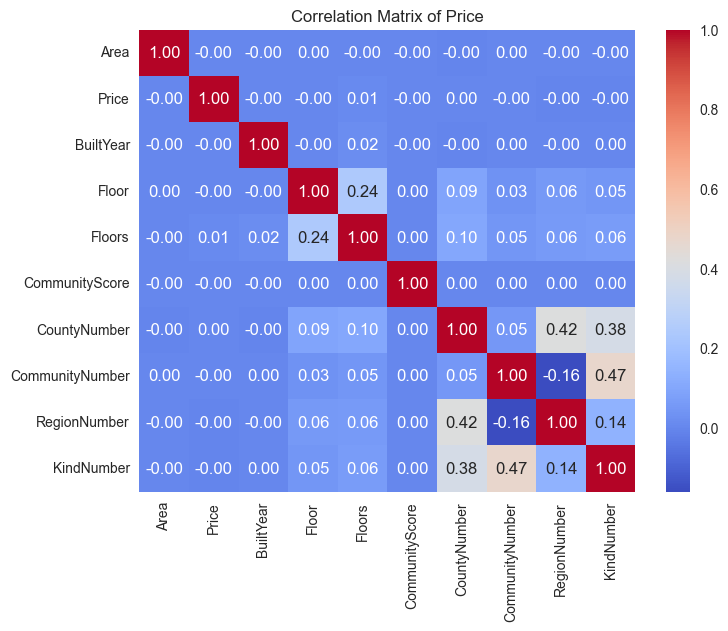

In [11]:
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Price')

In [12]:
df_original .isnull()

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,False,True,False,False,False,False,False,True,True,True,...,True,False,False,False,False,False,False,True,True,False
1,False,True,False,False,False,False,False,True,True,True,...,True,False,False,False,False,False,False,True,True,False
2,False,True,False,False,False,False,False,True,True,True,...,True,False,False,False,False,False,False,True,True,False
3,False,True,False,False,False,False,False,True,True,True,...,True,False,False,False,False,False,False,True,False,False
4,False,True,False,False,False,False,False,True,True,True,...,True,False,False,False,False,False,False,True,False,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1133882,False,True,False,False,False,False,True,True,True,True,...,True,False,False,False,False,False,False,True,False,False
1133883,False,True,False,False,False,False,True,True,True,True,...,True,False,False,False,False,False,False,True,False,False
1133884,False,True,False,False,False,False,True,True,True,True,...,True,False,False,False,False,False,False,True,False,False
1133885,False,True,False,False,False,False,True,True,True,True,...,True,False,False,False,False,False,False,True,False,False


In [13]:
df_original .isnull().sum()

SaleId                             0
OriginalId                   1133887
PortalId                           0
Title                              0
Description                     8664
Area                            3393
Price                          53424
OfferPrice                   1050699
RealPriceAfterRenovation     1050699
OriginalPrice                1023184
PricePerSquareMeter            57801
NumberOfRooms                  14847
BuiltYear                     382478
Type                               0
BuildingType                  206452
BuildingCondition            1055766
OfferFrom                       5031
Floor                          58979
Floors                        505193
TypeOfMarket                   33527
OwnerType                     545555
DateAddedToDatabase                0
DateAdded                          0
DateLastModification          886552
DateLastRaises                835087
NewestDate                         0
AvailableFrom                1133887
L

In [14]:
df_cleaned = df_original.copy()

In [15]:
df_beznull_price = df_original .dropna(subset=['Area'])

In [16]:
df_beznull_price.isnull().sum()

SaleId                             0
OriginalId                   1130494
PortalId                           0
Title                              0
Description                     7348
Area                               0
Price                          53291
OfferPrice                   1047306
RealPriceAfterRenovation     1047306
OriginalPrice                1019890
PricePerSquareMeter            54408
NumberOfRooms                  12124
BuiltYear                     379203
Type                               0
BuildingType                  204053
BuildingCondition            1052403
OfferFrom                       4742
Floor                          56314
Floors                        501959
TypeOfMarket                   32011
OwnerType                     542422
DateAddedToDatabase                0
DateAdded                          0
DateLastModification          883586
DateLastRaises                832330
NewestDate                         0
AvailableFrom                1130494
L

In [17]:
# df_beznull_price2 = df_beznull_price.sort_values('Area').interpolate()

In [18]:
df_beznull_price.head(20)

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,88,NaN,14,Mieszkanie trzypokojowe na sprzedaż,Mieszkanie o powierzchni 73m2 znajduje się na ...,73.00,766500.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,NaN,02TgImo1wm-Ra4zUQxoPBw==
1,99,NaN,19,Sprzedam mieszkanie na parterze 64.8m2 Białyst...,Sprzedam mieszkanie na parterze 64.8m2 w 3-pię...,64.80,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Antoniuk",20.0,61.0,1.0,1.0,922426.0,NaN,NaN,D-NUdVbtN3_kIW7ExgXkvA==
2,115,NaN,3,"Mieszkanie bezczynszowe, 3 pokoje, 2 łazienki",SPRZEDAŻ WYŁĄCZNIE BEZPOŚREDNIA. Agencjom nier...,51.00,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bagnówka",20.0,61.0,1.0,1.0,922461.0,NaN,NaN,lmBSU1XiXLSLOq1yKSe2kA==
3,140,NaN,14,Mieszkanie trzypokojowe na sprzedaż,***Oferta bez prowizji biura i podatku PCC!***...,67.62,544000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Józefa Karola Puchal...",20.0,61.0,1.0,1.0,922410.0,NaN,43141.0,HWachf5gb6Vq-sFYH4YWnA==
4,145,NaN,3,3 Pokoje- 48M2-Osiedle Dziesięciny,Przedstawiamy na sprzedaż 3 pokojowe mieszkani...,48.00,459000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Dziesięciny",20.0,61.0,1.0,1.0,922410.0,NaN,4656.0,AWsmt4ZY0X7lNv-6fSCn9Q==
5,159,NaN,3,"Mieszkanie, 87 m², Białystok","Przestronne, jasne mieszkanie na zamkniętym os...",87.00,779000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Adama Mickiewicza",20.0,61.0,1.0,1.0,922410.0,NaN,12740.0,SEPz6jrRB1vuWWYOn99h7g==
6,165,NaN,3,Przytulne mieszkanie blisko centrum!,Na sprzedaż 2 pokojowe mieszkanie położone na ...,34.10,359000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,16041.0,Gt5-LUpJNg-wBgBd8-hxGQ==
7,173,NaN,3,"**Jasne, 2 Pokojowe Mieszkanie, Widok Na Miasto**","Mieszkanie o powierzchni 35,7 m2 Ul. Jarzębino...",35.70,380000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok",20.0,61.0,1.0,1.0,922410.0,NaN,7290.0,a5iP5JQyibefTTLgBRU8oA==
8,179,NaN,3,*Bezpośrednio*PIĘKNY APARTAMENT w Centrum Lipo...,***REZERWACJA ***WYJĄTKOWA PROPOZYCJA DLA WYMA...,39.40,559000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Adama Mickiewicza",20.0,61.0,1.0,1.0,922410.0,NaN,12740.0,C_F7Bxl4hKQ2a2votBqs-g==
9,189,NaN,4,2-pokojowe mieszkanie na sprzedaż,Na sprzedaż 2 pokojowe mieszkanie położone na ...,34.20,354000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Piasta",20.0,61.0,1.0,1.0,922410.0,NaN,16041.0,XylelQthYlIn_7k8orxBfQ==


In [19]:
Q1 = df_beznull_price["Price"].quantile(0.25)
Q3 = df_beznull_price["Price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_price_p = df_beznull_price[~((df_beznull_price["Price"] < lower_bound) | (df_beznull_price["Price"] > upper_bound))]

In [20]:
Q1 = df_price_p["PricePerSquareMeter"].quantile(0.25)
Q3 = df_price_p["PricePerSquareMeter"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_price_a = df_price_p[~((df_price_p["PricePerSquareMeter"] < lower_bound) | (df_price_p["PricePerSquareMeter"] > upper_bound))]


In [21]:
Q1 = df_price_a["Area"].quantile(0.25)
Q3 = df_price_a["Area"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_price1 = df_price_a[~((df_price_a["Area"] < lower_bound) | (df_price_a["Area"] > upper_bound))]

In [22]:
df_price1['BuiltYear'] = pd.to_datetime(df_price1['BuiltYear'], format='%Y', errors='coerce')

In [23]:
df_price1.head(20)

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,88,NaN,14,Mieszkanie trzypokojowe na sprzedaż,Mieszkanie o powierzchni 73m2 znajduje się na ...,73.00,766500.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,NaN,02TgImo1wm-Ra4zUQxoPBw==
1,99,NaN,19,Sprzedam mieszkanie na parterze 64.8m2 Białyst...,Sprzedam mieszkanie na parterze 64.8m2 w 3-pię...,64.80,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Antoniuk",20.0,61.0,1.0,1.0,922426.0,NaN,NaN,D-NUdVbtN3_kIW7ExgXkvA==
2,115,NaN,3,"Mieszkanie bezczynszowe, 3 pokoje, 2 łazienki",SPRZEDAŻ WYŁĄCZNIE BEZPOŚREDNIA. Agencjom nier...,51.00,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bagnówka",20.0,61.0,1.0,1.0,922461.0,NaN,NaN,lmBSU1XiXLSLOq1yKSe2kA==
3,140,NaN,14,Mieszkanie trzypokojowe na sprzedaż,***Oferta bez prowizji biura i podatku PCC!***...,67.62,544000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Józefa Karola Puchal...",20.0,61.0,1.0,1.0,922410.0,NaN,43141.0,HWachf5gb6Vq-sFYH4YWnA==
4,145,NaN,3,3 Pokoje- 48M2-Osiedle Dziesięciny,Przedstawiamy na sprzedaż 3 pokojowe mieszkani...,48.00,459000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Dziesięciny",20.0,61.0,1.0,1.0,922410.0,NaN,4656.0,AWsmt4ZY0X7lNv-6fSCn9Q==
5,159,NaN,3,"Mieszkanie, 87 m², Białystok","Przestronne, jasne mieszkanie na zamkniętym os...",87.00,779000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Adama Mickiewicza",20.0,61.0,1.0,1.0,922410.0,NaN,12740.0,SEPz6jrRB1vuWWYOn99h7g==
6,165,NaN,3,Przytulne mieszkanie blisko centrum!,Na sprzedaż 2 pokojowe mieszkanie położone na ...,34.10,359000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,16041.0,Gt5-LUpJNg-wBgBd8-hxGQ==
7,173,NaN,3,"**Jasne, 2 Pokojowe Mieszkanie, Widok Na Miasto**","Mieszkanie o powierzchni 35,7 m2 Ul. Jarzębino...",35.70,380000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok",20.0,61.0,1.0,1.0,922410.0,NaN,7290.0,a5iP5JQyibefTTLgBRU8oA==
8,179,NaN,3,*Bezpośrednio*PIĘKNY APARTAMENT w Centrum Lipo...,***REZERWACJA ***WYJĄTKOWA PROPOZYCJA DLA WYMA...,39.40,559000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Adama Mickiewicza",20.0,61.0,1.0,1.0,922410.0,NaN,12740.0,C_F7Bxl4hKQ2a2votBqs-g==
9,189,NaN,4,2-pokojowe mieszkanie na sprzedaż,Na sprzedaż 2 pokojowe mieszkanie położone na ...,34.20,354000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Piasta",20.0,61.0,1.0,1.0,922410.0,NaN,16041.0,XylelQthYlIn_7k8orxBfQ==


In [24]:
df_price1.describe().T

,count,mean,min,25%,50%,75%,max,std
SaleId,1019895.0,2785334.786497,88.0,2032076.0,3026910.0,3765616.5,4418406.0,1216312.819628
OriginalId,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PortalId,1019895.0,10.468412,1.0,3.0,10.0,17.0,44.0,8.734634
Area,1019895.0,51.235749,6.87,40.0,49.86,61.0,96.17,15.155208
Price,968696.0,534743.792921,0.0,355000.0,499000.0,680681.125,1319000.0,241685.26195
OfferPrice,76990.0,569634.010829,54000.0,397434.0,535000.0,699000.0,3300000.0,231145.324617
RealPriceAfterRenovation,76990.0,940407.259452,85000.0,503635.2475,676333.33,904333.33,334234237.0,6197016.106829
OriginalPrice,101360.0,14239892.054544,1.0,355000.0,499000.0,684000.0,857460922000.0,3163320460.728683
PricePerSquareMeter,967666.0,10724.361855,0.0,7500.0,10170.695,13573.5675,23030.71,4338.931513
NumberOfRooms,1009140.0,7482.849491,1.0,2.0,2.0,3.0,792501237.0,2196237.851599


In [25]:
df_price1["Price"].value_counts(normalize=True)

Price
599000.0    0.009037
499000.0    0.008885
399000.0    0.008473
699000.0    0.007991
299000.0    0.006834
              ...   
629788.0    0.000001
626801.0    0.000001
848928.0    0.000001
849517.0    0.000001
374029.0    0.000001
Name: proportion, Length: 117663, dtype: float64

In [26]:
#df_price2 = df_price1.sort_values('Price').interpolate()

In [27]:
df_price1.nunique()

SaleId                       1019895
OriginalId                         0
PortalId                          35
Title                         573126
Description                   882354
Area                            8171
Price                         117663
OfferPrice                     21409
RealPriceAfterRenovation       26948
OriginalPrice                  15696
PricePerSquareMeter           268912
NumberOfRooms                     72
BuiltYear                        222
Type                               2
BuildingType                       4
BuildingCondition                  4
OfferFrom                          2
Floor                             49
Floors                            64
TypeOfMarket                       2
OwnerType                         90
DateAddedToDatabase           976917
DateAdded                     964655
DateLastModification          218341
DateLastRaises                261071
NewestDate                    967284
AvailableFrom                      0
L

In [28]:
df_price1.head(10)

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,88,NaN,14,Mieszkanie trzypokojowe na sprzedaż,Mieszkanie o powierzchni 73m2 znajduje się na ...,73.00,766500.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,NaN,02TgImo1wm-Ra4zUQxoPBw==
1,99,NaN,19,Sprzedam mieszkanie na parterze 64.8m2 Białyst...,Sprzedam mieszkanie na parterze 64.8m2 w 3-pię...,64.80,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Antoniuk",20.0,61.0,1.0,1.0,922426.0,NaN,NaN,D-NUdVbtN3_kIW7ExgXkvA==
2,115,NaN,3,"Mieszkanie bezczynszowe, 3 pokoje, 2 łazienki",SPRZEDAŻ WYŁĄCZNIE BEZPOŚREDNIA. Agencjom nier...,51.00,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bagnówka",20.0,61.0,1.0,1.0,922461.0,NaN,NaN,lmBSU1XiXLSLOq1yKSe2kA==
3,140,NaN,14,Mieszkanie trzypokojowe na sprzedaż,***Oferta bez prowizji biura i podatku PCC!***...,67.62,544000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Józefa Karola Puchal...",20.0,61.0,1.0,1.0,922410.0,NaN,43141.0,HWachf5gb6Vq-sFYH4YWnA==
4,145,NaN,3,3 Pokoje- 48M2-Osiedle Dziesięciny,Przedstawiamy na sprzedaż 3 pokojowe mieszkani...,48.00,459000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Dziesięciny",20.0,61.0,1.0,1.0,922410.0,NaN,4656.0,AWsmt4ZY0X7lNv-6fSCn9Q==
5,159,NaN,3,"Mieszkanie, 87 m², Białystok","Przestronne, jasne mieszkanie na zamkniętym os...",87.00,779000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Adama Mickiewicza",20.0,61.0,1.0,1.0,922410.0,NaN,12740.0,SEPz6jrRB1vuWWYOn99h7g==
6,165,NaN,3,Przytulne mieszkanie blisko centrum!,Na sprzedaż 2 pokojowe mieszkanie położone na ...,34.10,359000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,16041.0,Gt5-LUpJNg-wBgBd8-hxGQ==
7,173,NaN,3,"**Jasne, 2 Pokojowe Mieszkanie, Widok Na Miasto**","Mieszkanie o powierzchni 35,7 m2 Ul. Jarzębino...",35.70,380000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok",20.0,61.0,1.0,1.0,922410.0,NaN,7290.0,a5iP5JQyibefTTLgBRU8oA==
8,179,NaN,3,*Bezpośrednio*PIĘKNY APARTAMENT w Centrum Lipo...,***REZERWACJA ***WYJĄTKOWA PROPOZYCJA DLA WYMA...,39.40,559000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Adama Mickiewicza",20.0,61.0,1.0,1.0,922410.0,NaN,12740.0,C_F7Bxl4hKQ2a2votBqs-g==
9,189,NaN,4,2-pokojowe mieszkanie na sprzedaż,Na sprzedaż 2 pokojowe mieszkanie położone na ...,34.20,354000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Piasta",20.0,61.0,1.0,1.0,922410.0,NaN,16041.0,XylelQthYlIn_7k8orxBfQ==


In [29]:
unique_btype=df_price1['BuildingType'].unique()

unique_btype

array(['Blok', nan, 'Apartamentowiec', 'Kamienica', 'Pozostałe'],
      dtype=object)

In [30]:
print(df_price1['Price'].nunique())

117663


In [31]:
print(df_price1['Price'].value_counts())

Price
599000.0    8754
499000.0    8607
399000.0    8208
699000.0    7741
299000.0    6620
            ... 
629788.0       1
626801.0       1
848928.0       1
849517.0       1
374029.0       1
Name: count, Length: 117663, dtype: int64


In [32]:
df_price1.isnull().sum()

SaleId                             0
OriginalId                   1019895
PortalId                           0
Title                              0
Description                     6232
Area                               0
Price                          51199
OfferPrice                    942905
RealPriceAfterRenovation      942905
OriginalPrice                 918535
PricePerSquareMeter            52229
NumberOfRooms                  10755
BuiltYear                     355447
Type                               0
BuildingType                  185268
BuildingCondition             948805
OfferFrom                       4574
Floor                          49323
Floors                        456865
TypeOfMarket                   29083
OwnerType                     489606
DateAddedToDatabase                0
DateAdded                          0
DateLastModification          797740
DateLastRaises                754002
NewestDate                         0
AvailableFrom                1019895
L

In [33]:
df_price2 = df_price1.dropna(subset=['Price'])

In [34]:
df_price2.isnull().sum()

SaleId                            0
OriginalId                   968696
PortalId                          0
Title                             0
Description                    6033
Area                              0
Price                             0
OfferPrice                   891706
RealPriceAfterRenovation     891706
OriginalPrice                867336
PricePerSquareMeter            1087
NumberOfRooms                 10648
BuiltYear                    339100
Type                              0
BuildingType                 153500
BuildingCondition            904569
OfferFrom                       789
Floor                         48234
Floors                       436534
TypeOfMarket                  27802
OwnerType                    466260
DateAddedToDatabase               0
DateAdded                         0
DateLastModification         747906
DateLastRaises               717920
NewestDate                        0
AvailableFrom                968696
Link                        

In [35]:
df_cleaned = df_cleaned.dropna(subset=['Area', 'Price'])

In [36]:
df_cleaned.isnull().sum()

SaleId                             0
OriginalId                   1077203
PortalId                           0
Title                              0
Description                     7141
Area                               0
Price                              0
OfferPrice                    994015
RealPriceAfterRenovation      994015
OriginalPrice                 966599
PricePerSquareMeter             1177
NumberOfRooms                  12004
BuiltYear                     362100
Type                               0
BuildingType                  171231
BuildingCondition            1006261
OfferFrom                        845
Floor                          55176
Floors                        480735
TypeOfMarket                   30655
OwnerType                     518216
DateAddedToDatabase                0
DateAdded                          0
DateLastModification          831718
DateLastRaises                794726
NewestDate                         0
AvailableFrom                1077203
L

In [37]:
Q1 = df_cleaned["Price"].quantile(0.25)
Q3 = df_cleaned["Price"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned_p = df_cleaned[~((df_cleaned["Price"] < lower_bound) | (df_cleaned["Price"] > upper_bound))]

In [38]:
Q1 = df_cleaned_p["PricePerSquareMeter"].quantile(0.25)
Q3 = df_cleaned_p["PricePerSquareMeter"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned_a = df_cleaned_p[~((df_cleaned_p["PricePerSquareMeter"] < lower_bound) | (df_cleaned_p["PricePerSquareMeter"] > upper_bound))]


In [39]:
Q1 = df_cleaned_a["Area"].quantile(0.25)
Q3 = df_cleaned_a["Area"].quantile(0.75)
IQR = Q3 - Q1

lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

df_cleaned = df_cleaned_a[~((df_cleaned_a["Area"] < lower_bound) | (df_cleaned_a["Area"] > upper_bound))]

In [40]:
df_cleaned['BuiltYear'] = pd.to_datetime(df_cleaned['BuiltYear'], format='%Y', errors='coerce')

In [41]:
df_cleaned = df_cleaned.dropna(subset=['Location'])
print(f"Rozmiar df_cleaned po usunięciu NaN z Location: {df_cleaned.shape}")
display(df_cleaned.isnull().sum())

Rozmiar df_cleaned po usunięciu NaN z Location: (967332, 51)


SaleId                            0
OriginalId                   967332
PortalId                          0
Title                             0
Description                    6020
Area                              0
Price                             0
OfferPrice                   890378
RealPriceAfterRenovation     890378
OriginalPrice                866079
PricePerSquareMeter            1085
NumberOfRooms                 10623
BuiltYear                    338639
Type                              0
BuildingType                 153080
BuildingCondition            903272
OfferFrom                       788
Floor                         48120
Floors                       435701
TypeOfMarket                  27724
OwnerType                    465424
DateAddedToDatabase               0
DateAdded                         0
DateLastModification         746821
DateLastRaises               716866
NewestDate                        0
AvailableFrom                967332
Link                        

# Sprawdzenie braków - procentowo.

In [42]:
df_price2.isna().sum() / len(df_original) * 100

SaleId                        0.000000
OriginalId                   85.431441
PortalId                      0.000000
Title                         0.000000
Description                   0.532064
Area                          0.000000
Price                         0.000000
OfferPrice                   78.641522
RealPriceAfterRenovation     78.641522
OriginalPrice                76.492278
PricePerSquareMeter           0.095865
NumberOfRooms                 0.939071
BuiltYear                    29.905978
Type                          0.000000
BuildingType                 13.537504
BuildingCondition            79.775939
OfferFrom                     0.069584
Floor                         4.253863
Floors                       38.498898
TypeOfMarket                  2.451920
OwnerType                    41.120500
DateAddedToDatabase           0.000000
DateAdded                     0.000000
DateLastModification         65.959483
DateLastRaises               63.314951
NewestDate               

In [43]:
# parametr thresh pozwala określić minimalną liczbę nie-NaN wartości, które muszą być w wierszu/kolumnie
display(df_price2.head())
df_price2.dropna(thresh=(0.4*len(df_price2)),axis=1).head()

,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,Archive,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,SubRegionNumber,StreetNumber,EncryptedId
0,88,NaN,14,Mieszkanie trzypokojowe na sprzedaż,Mieszkanie o powierzchni 73m2 znajduje się na ...,73.00,766500.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,NaN,02TgImo1wm-Ra4zUQxoPBw==
1,99,NaN,19,Sprzedam mieszkanie na parterze 64.8m2 Białyst...,Sprzedam mieszkanie na parterze 64.8m2 w 3-pię...,64.80,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Antoniuk",20.0,61.0,1.0,1.0,922426.0,NaN,NaN,D-NUdVbtN3_kIW7ExgXkvA==
2,115,NaN,3,"Mieszkanie bezczynszowe, 3 pokoje, 2 łazienki",SPRZEDAŻ WYŁĄCZNIE BEZPOŚREDNIA. Agencjom nier...,51.00,540000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Bagnówka",20.0,61.0,1.0,1.0,922461.0,NaN,NaN,lmBSU1XiXLSLOq1yKSe2kA==
3,140,NaN,14,Mieszkanie trzypokojowe na sprzedaż,***Oferta bez prowizji biura i podatku PCC!***...,67.62,544000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Józefa Karola Puchal...",20.0,61.0,1.0,1.0,922410.0,NaN,43141.0,HWachf5gb6Vq-sFYH4YWnA==
4,145,NaN,3,3 Pokoje- 48M2-Osiedle Dziesięciny,Przedstawiamy na sprzedaż 3 pokojowe mieszkani...,48.00,459000.0,NaN,NaN,NaN,...,NaN,"Podlaskie, Białystok, Ul. Dziesięciny",20.0,61.0,1.0,1.0,922410.0,NaN,4656.0,AWsmt4ZY0X7lNv-6fSCn9Q==


,SaleId,PortalId,Title,Description,Area,Price,PricePerSquareMeter,NumberOfRooms,BuiltYear,Type,...,NumberOfCommunityComments,NumberOfCommunityOpinions,Location,VoivodeshipNumber,CountyNumber,CommunityNumber,KindNumber,RegionNumber,StreetNumber,EncryptedId
0,88,14,Mieszkanie trzypokojowe na sprzedaż,Mieszkanie o powierzchni 73m2 znajduje się na ...,73.00,766500.0,10500.00,3.0,2005-01-01,Mieszkania,...,NaN,NaN,"Podlaskie, Białystok, Bojary",20.0,61.0,1.0,1.0,922490.0,NaN,02TgImo1wm-Ra4zUQxoPBw==
1,99,19,Sprzedam mieszkanie na parterze 64.8m2 Białyst...,Sprzedam mieszkanie na parterze 64.8m2 w 3-pię...,64.80,540000.0,8333.33,3.0,NaT,Mieszkania,...,NaN,NaN,"Podlaskie, Białystok, Antoniuk",20.0,61.0,1.0,1.0,922426.0,NaN,D-NUdVbtN3_kIW7ExgXkvA==
2,115,3,"Mieszkanie bezczynszowe, 3 pokoje, 2 łazienki",SPRZEDAŻ WYŁĄCZNIE BEZPOŚREDNIA. Agencjom nier...,51.00,540000.0,10588.00,3.0,2013-01-01,Mieszkania,...,NaN,NaN,"Podlaskie, Białystok, Bagnówka",20.0,61.0,1.0,1.0,922461.0,NaN,lmBSU1XiXLSLOq1yKSe2kA==
3,140,14,Mieszkanie trzypokojowe na sprzedaż,***Oferta bez prowizji biura i podatku PCC!***...,67.62,544000.0,8044.96,3.0,2023-01-01,Mieszkania,...,NaN,NaN,"Podlaskie, Białystok, Ul. Józefa Karola Puchal...",20.0,61.0,1.0,1.0,922410.0,43141.0,HWachf5gb6Vq-sFYH4YWnA==
4,145,3,3 Pokoje- 48M2-Osiedle Dziesięciny,Przedstawiamy na sprzedaż 3 pokojowe mieszkani...,48.00,459000.0,9563.00,3.0,NaT,Mieszkania,...,NaN,NaN,"Podlaskie, Białystok, Ul. Dziesięciny",20.0,61.0,1.0,1.0,922410.0,4656.0,AWsmt4ZY0X7lNv-6fSCn9Q==


In [44]:
df_price2.isnull().sum()

SaleId                            0
OriginalId                   968696
PortalId                          0
Title                             0
Description                    6033
Area                              0
Price                             0
OfferPrice                   891706
RealPriceAfterRenovation     891706
OriginalPrice                867336
PricePerSquareMeter            1087
NumberOfRooms                 10648
BuiltYear                    339100
Type                              0
BuildingType                 153500
BuildingCondition            904569
OfferFrom                       789
Floor                         48234
Floors                       436534
TypeOfMarket                  27802
OwnerType                    466260
DateAddedToDatabase               0
DateAdded                         0
DateLastModification         747906
DateLastRaises               717920
NewestDate                        0
AvailableFrom                968696
Link                        

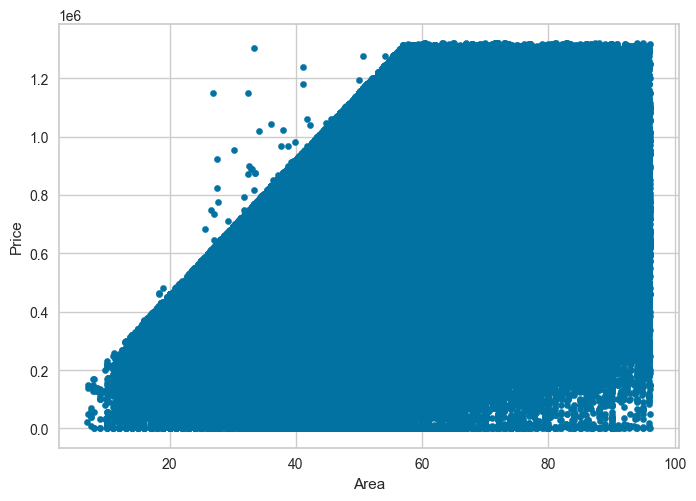

In [45]:
df_price2.plot.scatter(x='Area', y='Price');

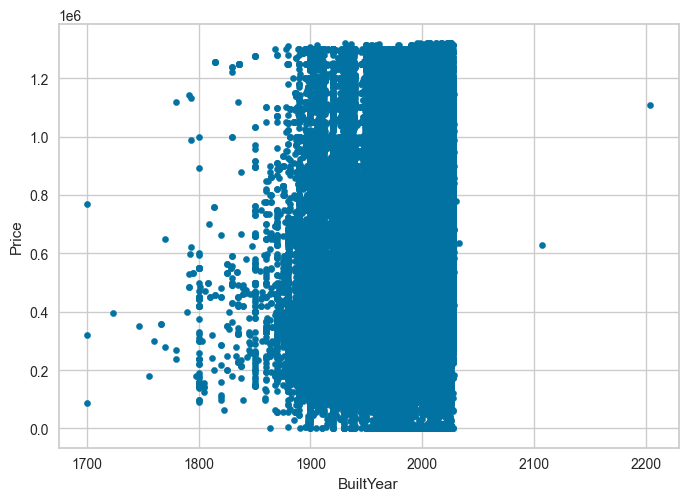

In [46]:
df_price2.plot.scatter(x='BuiltYear', y='Price');

Text(0.5, 1.0, 'Correlation Matrix of Price')

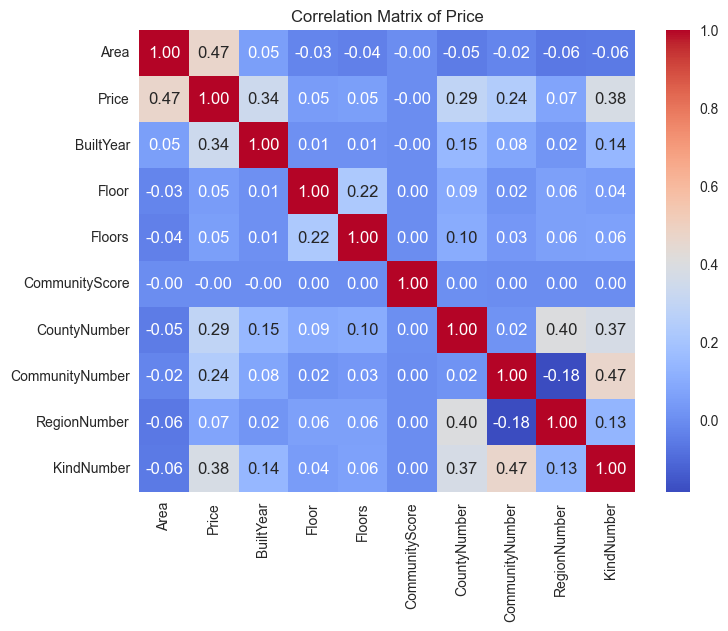

In [47]:
correlation_matrix = df_price2[['Area', 'Price', 'BuiltYear', 'Floor', 'Floors', 'CommunityScore', 'CountyNumber', 'CommunityNumber',
                               'RegionNumber','KindNumber']].corr()

plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Price')

In [48]:
df_price2 = df_price2.dropna(subset=['Location'])

In [49]:
sale_ids = df_price2['SaleId'].reset_index(drop=True)

In [50]:
train_df = df_cleaned.sample(frac=0.9, random_state=42)
holdout_df = df_cleaned.drop(train_df.index)

print(f"Rozmiar zbioru treningowego: {train_df.shape}")
print(f"Rozmiar zbioru holdout: {holdout_df.shape}")

Rozmiar zbioru treningowego: (870599, 51)
Rozmiar zbioru holdout: (96733, 51)


In [51]:
def convert_column_types(df_to_convert):
    df_copy = df_to_convert.copy() # Pracuj na kopii, aby uniknąć SettingWithCopyWarning
    str_cols = ['VoivodeshipNumber', 'CountyNumber', 'CommunityNumber', 'KindNumber', 'RegionNumber']
    for col in str_cols:
        if col in df_copy.columns:
            df_copy[col] = df_copy[col].astype(str)
    
    # BuiltYear powinno być już datetime, ale można sprawdzić/ponowić konwersję
    if 'BuiltYear' in df_copy.columns:
         df_copy['BuiltYear'] = pd.to_datetime(df_copy['BuiltYear'], format='%Y', errors='coerce')
    
    if 'StreetNumber' in df_copy.columns:
        df_copy['StreetNumber'] = df_copy['StreetNumber'].astype(str)
    return df_copy

train_df = convert_column_types(train_df)
holdout_df = convert_column_types(holdout_df)

print("Typy danych w train_df po konwersji:")
train_df.info()
print("\nTypy danych w holdout_df po konwersji:")
holdout_df.info()

Typy danych w train_df po konwersji:
<class 'pandas.core.frame.DataFrame'>
Index: 870599 entries, 883814 to 497984
Data columns (total 51 columns):
 #   Column                     Non-Null Count   Dtype         
---  ------                     --------------   -----         
 0   SaleId                     870599 non-null  int64         
 1   OriginalId                 0 non-null       float64       
 2   PortalId                   870599 non-null  int64         
 3   Title                      870599 non-null  object        
 4   Description                865187 non-null  object        
 5   Area                       870599 non-null  float64       
 6   Price                      870599 non-null  float64       
 7   OfferPrice                 69205 non-null   float64       
 8   RealPriceAfterRenovation   69205 non-null   float64       
 9   OriginalPrice              91019 non-null   float64       
 10  PricePerSquareMeter        869608 non-null  float64       
 11  NumberOfRooms  

In [52]:
df_price2['VoivodeshipNumber'] = df_price2['VoivodeshipNumber'].astype(str)
df_price2['CountyNumber'] = df_price2['CountyNumber'].astype(str)
df_price2['CommunityNumber'] = df_price2['CommunityNumber'].astype(str)
df_price2['KindNumber'] = df_price2['KindNumber'].astype(str)
df_price2['RegionNumber'] = df_price2['RegionNumber'].astype(str)
df_price2['BuiltYear'] = pd.to_datetime(df_price2['BuiltYear'], format='%Y', errors='coerce')
if 'StreetNumber' in df_price2.columns:
    df_price2['StreetNumber'] = df_price2['StreetNumber'].astype(str)

In [53]:
from sklearn.feature_extraction.text import TfidfVectorizer

location_vectorizer = TfidfVectorizer(
    max_features=1000, 
    stop_words=None,
    ngram_range=(1, 1),
    min_df=5,
    max_df=0.95
)

In [55]:
print("Przetwarzanie TF-IDF dla zbioru treningowego...")
train_df['Location_Clean'] = train_df['Location'].fillna('').astype(str)
# Dopasuj i przekształć ZBIÓR TRENINGOWY
train_location_tfidf_features = location_vectorizer.fit_transform(train_df['Location_Clean'])

try:
    feature_names = location_vectorizer.get_feature_names_out()
except AttributeError:
    feature_names = location_vectorizer.get_feature_names_() # Dla starszych wersji sklearn
    
train_location_tfidf_df = pd.DataFrame(
    train_location_tfidf_features.toarray(),
    columns=['loc_tfidf_' + name for name in feature_names],
    index=train_df.index
)
print(f"Utworzono {train_location_tfidf_df.shape[1]} cech TF-IDF dla zbioru treningowego.")

# Połącz z train_df i usuń oryginalne/pośrednie kolumny Location
train_df_processed = pd.concat(
    [train_df.drop(columns=['Location', 'Location_Clean'], errors='ignore'), train_location_tfidf_df], 
    axis=1
)
train_df_processed=train_df_processed[train_df_processed['Price'] >= 200000]
display(train_df_processed.head())

Przetwarzanie TF-IDF dla zbioru treningowego...
Utworzono 1000 cech TF-IDF dla zbioru treningowego.


,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,loc_tfidf_żerań,loc_tfidf_żeromskiego,loc_tfidf_żniński,loc_tfidf_żoliborz,loc_tfidf_żory,loc_tfidf_żukowo,loc_tfidf_żwirki,loc_tfidf_żyrardowski,loc_tfidf_żyrardów,loc_tfidf_żywiecki
883814,3851719,NaN,3,"Mieszkanie 2 pok. 43,15m2/ Miejsca postojowe !",ODDANIE INWESTYCJI I KWARTAŁ 2025 ! Deweloper ...,43.15,409925.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
792382,3610777,NaN,19,Słoneczne mieszkanie na Kazimierzu! TOP LOKALI...,Sprzedam słoneczne mieszkanie na krakowskim Ka...,70.14,1250000.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
226227,1627348,NaN,19,Sprzedam mieszkanie,SPRZEDAM! Mieszkanie na 2 pietrze w centrum mi...,34.00,240000.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
266146,1925917,NaN,4,3-pokojowe mieszkanie na sprzedaż,Oferta sprzedaży 3 pokojowego mieszkania 62 m ...,62.00,680000.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
948118,4021959,NaN,18,NAROŻNE/WYSOKI STANDARD Z TARASEM.,Narożne mieszkanie na Białołęce w bloku z 2021...,70.80,1099000.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [56]:
print("Przetwarzanie TF-IDF dla zbioru holdout...")
holdout_df['Location_Clean'] = holdout_df['Location'].fillna('').astype(str)
# Przekształć ZBIÓR HOLDOUT używając już dopasowanego wektoryzatora
holdout_location_tfidf_features = location_vectorizer.transform(holdout_df['Location_Clean'])

holdout_location_tfidf_df = pd.DataFrame(
    holdout_location_tfidf_features.toarray(),
    columns=['loc_tfidf_' + name for name in feature_names], # Użyj tych samych feature_names
    index=holdout_df.index
)
print(f"Utworzono {holdout_location_tfidf_df.shape[1]} cech TF-IDF dla zbioru holdout.")

# Połącz z holdout_df i usuń oryginalne/pośrednie kolumny Location
holdout_df_processed = pd.concat(
    [holdout_df.drop(columns=['Location', 'Location_Clean'], errors='ignore'), holdout_location_tfidf_df],
    axis=1
)
display(holdout_df_processed.head())

Przetwarzanie TF-IDF dla zbioru holdout...
Utworzono 1000 cech TF-IDF dla zbioru holdout.


,SaleId,OriginalId,PortalId,Title,Description,Area,Price,OfferPrice,RealPriceAfterRenovation,OriginalPrice,...,loc_tfidf_żerań,loc_tfidf_żeromskiego,loc_tfidf_żniński,loc_tfidf_żoliborz,loc_tfidf_żory,loc_tfidf_żukowo,loc_tfidf_żwirki,loc_tfidf_żyrardowski,loc_tfidf_żyrardów,loc_tfidf_żywiecki
5,159,NaN,3,"Mieszkanie, 87 m², Białystok","Przestronne, jasne mieszkanie na zamkniętym os...",87.00,779000.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
14,230,NaN,3,Kawalerka Lipowa II Piętro BEZPOŚREDNIO,"Mieszkanie sprzedawane bezpośrednio, wszystkim...",24.10,310000.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
16,240,NaN,11,"Mieszkanie, Białystok, Zawady, 75 m²","Mieszkanie, Białystok, Zawady, 75 m² Ogłoszeni...",75.05,577000.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,338,NaN,3,4 Pokoje /Waszyngtona - na inwestycję / na wyn...,Mieszkanie idealne pod inwestycję - osiedle Pi...,59.80,495000.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
38,442,NaN,3,NOWE 33m wykończone + miejsce parkingowe w cenie!,"UNIKALNA OFERTA: Nowe, całkowicie urządzone dw...",33.00,438000.0,NaN,NaN,NaN,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [57]:
categorical_features_initial = [
    'BuildingType', 'BuildingCondition', 'TypeOfMarket', 'OwnerType', 'Type', 'OfferFrom',
    'VoivodeshipNumber', 'CountyNumber', 'CommunityNumber', 'KindNumber', 'RegionNumber'
]
# Cechy loc_tfidf_* zostaną automatycznie wykryte jako numeryczne
numeric_features_initial = [
    'Area', 'NumberOfRooms', 'Floor', 'Floors', 'CommunityScore'
]
date_features_initial = ['BuiltYear']

# Filtruj cechy na podstawie kolumn w train_df_processed
categorical_features_to_use = [col for col in categorical_features_initial if col in train_df_processed.columns]
numeric_features_to_use = [col for col in numeric_features_initial if col in train_df_processed.columns]
date_features_to_use = [col for col in date_features_initial if col in train_df_processed.columns]

ignore_features_list_setup = [ # Inna nazwa, żeby nie kolidowała z globalną listą z notebooka
    'SaleId', 'OriginalId', 'PortalId', 'Title', 'Description',
    'OfferPrice', 'RealPriceAfterRenovation', 'OriginalPrice',
    'PricePerSquareMeter', 'DateAddedToDatabase', 'DateAdded',
    'DateLastModification', 'DateLastRaises', 'NewestDate',
    'AvailableFrom', 'Link', 'Phone', 'MainImage', 'OtherImages',
    'NumberOfDuplicates', 'NumberOfRaises', 'NumberOfModifications',
    'IsDuplicatePriceLower', 'IsDuplicatePrivateOwner', 'Score', 'ScorePrecision',
    'NumberOfCommunityComments', 'NumberOfCommunityOpinions', 'Archive',
    'SubRegionNumber', 'EncryptedId',
    'StreetNumber', # Ignorujemy, bo może mieć zbyt wiele unikalnych wartości
    'Location',         # Już przetworzone
    'Location_Clean'    # Kolumna pomocnicza
]
# Filtruj ignorowane cechy, aby upewnić się, że są w DataFrame przekazywanym do setup
ignore_features_final = [col for col in ignore_features_list_setup if col in train_df_processed.columns]

print("--- Informacje przed PyCaret setup ---")
print("Kolumny w train_df_processed:", train_df_processed.columns.tolist())
print("Cechy kategoryczne:", categorical_features_to_use)
print("Cechy numeryczne (bez loc_tfidf):", numeric_features_to_use)
print("Cechy daty:", date_features_to_use)
print("Ignorowane cechy:", ignore_features_final)
print("------------------------------------")


--- Informacje przed PyCaret setup ---
Kolumny w train_df_processed: ['SaleId', 'OriginalId', 'PortalId', 'Title', 'Description', 'Area', 'Price', 'OfferPrice', 'RealPriceAfterRenovation', 'OriginalPrice', 'PricePerSquareMeter', 'NumberOfRooms', 'BuiltYear', 'Type', 'BuildingType', 'BuildingCondition', 'OfferFrom', 'Floor', 'Floors', 'TypeOfMarket', 'OwnerType', 'DateAddedToDatabase', 'DateAdded', 'DateLastModification', 'DateLastRaises', 'NewestDate', 'AvailableFrom', 'Link', 'Phone', 'MainImage', 'OtherImages', 'NumberOfDuplicates', 'NumberOfRaises', 'NumberOfModifications', 'IsDuplicatePriceLower', 'IsDuplicatePrivateOwner', 'Score', 'ScorePrecision', 'CommunityScore', 'NumberOfCommunityComments', 'NumberOfCommunityOpinions', 'Archive', 'VoivodeshipNumber', 'CountyNumber', 'CommunityNumber', 'KindNumber', 'RegionNumber', 'SubRegionNumber', 'StreetNumber', 'EncryptedId', 'loc_tfidf_11', 'loc_tfidf_adama', 'loc_tfidf_al', 'loc_tfidf_aleja', 'loc_tfidf_aleje', 'loc_tfidf_aleksandra', '

In [59]:
import os
# Utwórz dedykowany katalog dla tego testu, jeśli nie istnieje
current_directory = os.getcwd() 
local_mlruns_path = os.path.join(current_directory, "mlruns_DIRECT_LOCAL_TEST") 

if not os.path.exists(local_mlruns_path):
    os.makedirs(local_mlruns_path)
    print(f"Utworzono katalog: {local_mlruns_path}")
else:
    print(f"Katalog już istnieje: {local_mlruns_path}")

absolute_mlruns_path = os.path.abspath(local_mlruns_path)
tracking_uri = f"file:///{absolute_mlruns_path.replace(os.sep, '/')}"
mlflow.set_tracking_uri(tracking_uri)

print(f"MLflow tracking URI ustawione na: {mlflow.get_tracking_uri()}")

# MLFLOW_EXPERIMENT_NAME powinno być zdefiniowane wcześniej w Twoim notebooku
# np. MLFLOW_EXPERIMENT_NAME = 'Investoro_Ceny'

try:
    # Sprawdź, czy eksperyment istnieje
    experiment = mlflow.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)
    if experiment is None:
        # Jeśli nie istnieje, stwórz go.
        # Dla logowania typu 'file://', MLflow sam zarządzi lokalizacją artefaktów
        # w podkatalogach struktury 'mlruns'.
        experiment_id = mlflow.create_experiment(MLFLOW_EXPERIMENT_NAME)
        print(f"Utworzono nowy eksperyment MLflow: '{MLFLOW_EXPERIMENT_NAME}' o ID: {experiment_id}")
    else:
        experiment_id = experiment.experiment_id
        print(f"Znaleziono istniejący eksperyment: '{MLFLOW_EXPERIMENT_NAME}' o ID: {experiment_id}")
    
    # Ustaw eksperyment jako aktywny
    mlflow.set_experiment(experiment_name=MLFLOW_EXPERIMENT_NAME)
    print(f"Aktywny eksperyment MLflow ustawiony na: '{MLFLOW_EXPERIMENT_NAME}'")

except Exception as e:
    print(f"Błąd podczas ustawiania/tworzenia eksperymentu MLflow: {e}")
    import traceback
    print(traceback.format_exc())


# --- Twój kod przygotowujący train_df_processed, categorical_features_to_use, itd. powinien być tutaj ---
# Upewnij się, że te zmienne są zdefiniowane przed blokiem setup
# print("train_df_processed shape:", train_df_processed.shape)
# print("categorical_features_to_use:", categorical_features_to_use)
# print("numeric_features_to_use:", numeric_features_to_use)
# print("date_features_to_use:", date_features_to_use)
# print("ignore_features_final:", ignore_features_final)

Katalog już istnieje: C:\Users\Ai\Desktop\Tomek\Investoro\mlruns_DIRECT_LOCAL_TEST
MLflow tracking URI ustawione na: file:///C:/Users/Ai/Desktop/Tomek/Investoro/mlruns_DIRECT_LOCAL_TEST
Znaleziono istniejący eksperyment: 'Investoro_Ceny' o ID: 500365848108849592
Aktywny eksperyment MLflow ustawiony na: 'Investoro_Ceny'


In [60]:
transformed_exp = None # Inicjalizacja na wypadek błędu
try:
    transformed_exp = setup(
        data=train_df_processed, # WAŻNE: przekazujemy przetworzony zbiór treningowy
        target='Price',
        verbose=True,
        session_id=123,
        log_experiment=True,
        experiment_name=MLFLOW_EXPERIMENT_NAME, 
        log_data=True, 
        log_plots=True, 
        categorical_features=categorical_features_to_use,
        numeric_features=numeric_features_to_use, # PyCaret doda loc_tfidf_* automatycznie
        date_features=date_features_to_use,
        text_features=[], # WAŻNE: puste, bo 'Location' przetworzone ręcznie
        ignore_features=ignore_features_final,
        ordinal_features={'BuildingType': ['Pozostałe', 'Blok', 'Apartamentowiec', 'Kamienica'],
                          'BuildingCondition': ['For_Renovation', 'Good', 'After_Renovation', 'Developer_State']}
    )
except Exception as e:
    print(f"Błąd podczas setup PyCaret: {e}")
    import traceback
    print(traceback.format_exc())

if transformed_exp:
    best_transformed_model = compare_models()
    transformed_metrics_df = pull()
    display(transformed_metrics_df)
else:
    print("Nie udało się zainicjować eksperymentu PyCaret.")

,Description,Value
0,Session id,123
1,Target,Price
2,Target type,Regression
3,Original data shape,"(827668, 1050)"
4,Transformed data shape,"(827668, 1062)"
5,Transformed train set shape,"(579367, 1062)"
6,Transformed test set shape,"(248301, 1062)"
7,Ignore features,32
8,Ordinal features,2
9,Numeric features,5


2025/05/24 19:46:55 WARNING mlflow.utils.git_utils: Failed to import Git (the Git executable is probably not on your PATH), so Git SHA is not available. Error: Failed to initialize: Bad git executable.
The git executable must be specified in one of the following ways:
    - be included in your $PATH
    - be set via $GIT_PYTHON_GIT_EXECUTABLE
    - explicitly set via git.refresh(<full-path-to-git-executable>)

All git commands will error until this is rectified.

This initial message can be silenced or aggravated in the future by setting the
$GIT_PYTHON_REFRESH environment variable. Use one of the following values:
    - quiet|q|silence|s|silent|none|n|0: for no message or exception
    - warn|w|warning|log|l|1: for a warning message (logging level CRITICAL, displayed by default)
    - error|e|exception|raise|r|2: for a raised exception

Example:
    export GIT_PYTHON_REFRESH=quiet



,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,54360.3477,7384518100.5486,85930.8266,0.8605,0.1559,0.1060,357.6070
rf,Random Forest Regressor,56216.0244,7389691859.8910,85961.4365,0.8604,0.1559,0.1095,201.6440
lightgbm,Light Gradient Boosting Machine,73508.6534,10339543705.9476,101682.5929,0.8047,0.1829,0.1427,11.2530
knn,K Neighbors Regressor,73668.9086,11669694054.4000,108024.8820,0.7796,0.1958,0.1442,188.7320
gbr,Gradient Boosting Regressor,82468.2740,12624208648.1442,112356.5262,0.7616,0.2049,0.1633,81.2670
ridge,Ridge Regression,83232.1948,12845817793.6870,113338.2431,0.7574,0.2153,0.1643,9.3820
br,Bayesian Ridge,83233.2851,12846497443.6471,113341.2341,0.7574,0.2152,0.1643,30.1290
lasso,Lasso Regression,83260.5138,12854709354.4480,113377.4267,0.7572,0.2151,0.1643,144.2440
dt,Decision Tree Regressor,70068.8552,12960998314.4970,113843.8994,0.7552,0.2035,0.1349,13.9170
omp,Orthogonal Matching Pursuit,87827.8656,14109084231.5774,118780.0556,0.7335,0.2239,0.1740,9.2790


,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
et,Extra Trees Regressor,5.436035e+04,7.384518e+09,8.593083e+04,8.605000e-01,0.1559,1.060000e-01,357.607
rf,Random Forest Regressor,5.621602e+04,7.389692e+09,8.596144e+04,8.604000e-01,0.1559,1.095000e-01,201.644
lightgbm,Light Gradient Boosting Machine,7.350865e+04,1.033954e+10,1.016826e+05,8.047000e-01,0.1829,1.427000e-01,11.253
knn,K Neighbors Regressor,7.366891e+04,1.166969e+10,1.080249e+05,7.796000e-01,0.1958,1.442000e-01,188.732
gbr,Gradient Boosting Regressor,8.246827e+04,1.262421e+10,1.123565e+05,7.616000e-01,0.2049,1.633000e-01,81.267
ridge,Ridge Regression,8.323219e+04,1.284582e+10,1.133382e+05,7.574000e-01,0.2153,1.643000e-01,9.382
br,Bayesian Ridge,8.323329e+04,1.284650e+10,1.133412e+05,7.574000e-01,0.2152,1.643000e-01,30.129
lasso,Lasso Regression,8.326051e+04,1.285471e+10,1.133774e+05,7.572000e-01,0.2151,1.643000e-01,144.244
dt,Decision Tree Regressor,7.006886e+04,1.296100e+10,1.138439e+05,7.552000e-01,0.2035,1.349000e-01,13.917
omp,Orthogonal Matching Pursuit,8.782787e+04,1.410908e+10,1.187801e+05,7.335000e-01,0.2239,1.740000e-01,9.279


In [61]:
transformed_exp.X_train_transformed.info()

<class 'pandas.core.frame.DataFrame'>
Index: 579367 entries, 1096682 to 1050570
Columns: 1061 entries, Area to loc_tfidf_żywiecki
dtypes: float32(1005), float64(56)
memory usage: 2.4 GB


In [62]:
transformed_exp.X_train_transformed.head()

,Area,NumberOfRooms,Type,BuildingType_1.0,BuildingType_0.0,BuildingType_3.0,BuildingType_2.0,BuildingCondition_-1.0,OfferFrom,Floor,...,loc_tfidf_żerań,loc_tfidf_żeromskiego,loc_tfidf_żniński,loc_tfidf_żoliborz,loc_tfidf_żory,loc_tfidf_żukowo,loc_tfidf_żwirki,loc_tfidf_żyrardowski,loc_tfidf_żyrardów,loc_tfidf_żywiecki
1096682,38.000000,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
406021,76.800003,4.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
847939,68.000000,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
866463,62.000000,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
192325,75.000000,4.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


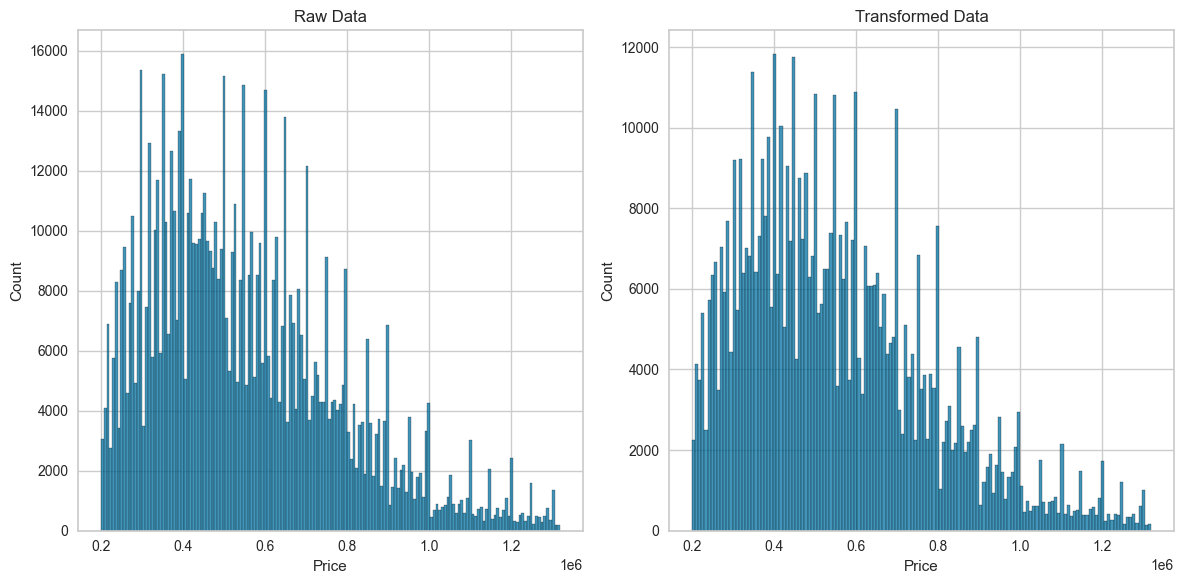

In [63]:
from pycaret.regression import get_config
import matplotlib.pyplot as plt
import seaborn as sns

# Wyciągnij dane oryginalne i przetransformowane
df_raw = train_df_processed.copy()
df_transformed = get_config("X_train").copy()
df_transformed["Price"] = get_config("y_train")

# Rysowanie wykresów
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

sns.histplot(df_raw["Price"], ax=axes[0])
axes[0].set_title("Raw Data")

sns.histplot(df_transformed["Price"], ax=axes[1])
axes[1].set_title("Transformed Data")

plt.tight_layout()
plt.show()

In [64]:
transformed_exp.dataset.head()

,Area,NumberOfRooms,BuiltYear,Type,BuildingType,BuildingCondition,OfferFrom,Floor,Floors,TypeOfMarket,...,loc_tfidf_żeromskiego,loc_tfidf_żniński,loc_tfidf_żoliborz,loc_tfidf_żory,loc_tfidf_żukowo,loc_tfidf_żwirki,loc_tfidf_żyrardowski,loc_tfidf_żyrardów,loc_tfidf_żywiecki,Price
1096682,38.000000,2.0,1973-01-01,Mieszkania,Blok,NaN,Agencja,4.0,4.0,Wtórny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,639000.0
406021,76.800003,4.0,2012-01-01,Mieszkania,Pozostałe,NaN,Agencja,0.0,1.0,Wtórny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,689000.0
847939,68.000000,3.0,1992-01-01,Mieszkania,NaN,NaN,Agencja,2.0,5.0,Wtórny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,799000.0
866463,62.000000,3.0,1984-01-01,Mieszkania,Blok,NaN,Agencja,0.0,4.0,Wtórny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,725000.0
192325,75.000000,4.0,NaT,Mieszkania,Kamienica,NaN,Agencja,3.0,NaN,Wtórny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,345000.0


In [65]:
transformed_exp.dataset_transformed.head()

,Area,NumberOfRooms,Type,BuildingType_1.0,BuildingType_0.0,BuildingType_3.0,BuildingType_2.0,BuildingCondition_-1.0,OfferFrom,Floor,...,loc_tfidf_żeromskiego,loc_tfidf_żniński,loc_tfidf_żoliborz,loc_tfidf_żory,loc_tfidf_żukowo,loc_tfidf_żwirki,loc_tfidf_żyrardowski,loc_tfidf_żyrardów,loc_tfidf_żywiecki,Price
1096682,38.000000,2.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,639000.0
406021,76.800003,4.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,689000.0
847939,68.000000,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,799000.0
866463,62.000000,3.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,725000.0
192325,75.000000,4.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,345000.0


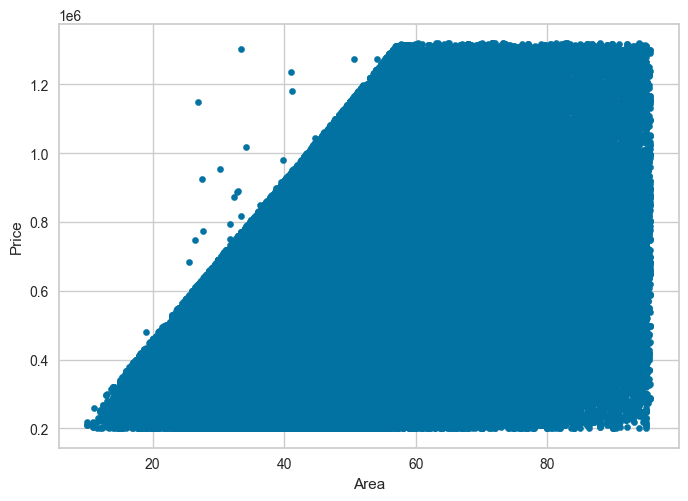

In [66]:
df_transformed.plot.scatter(x='Area', y='Price');

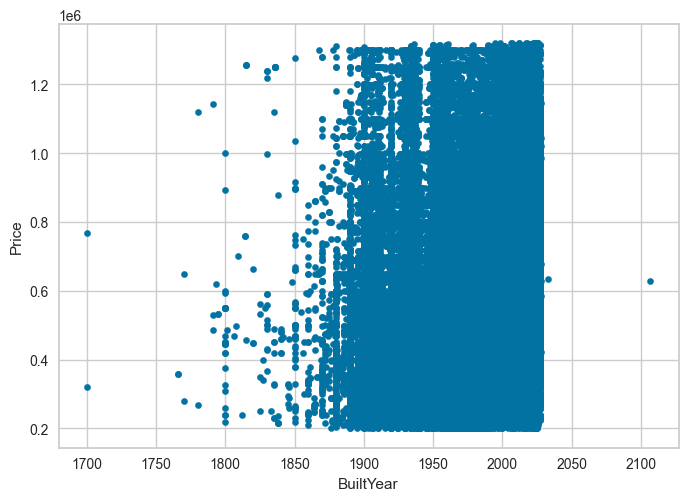

In [67]:
df_transformed.plot.scatter(x='BuiltYear', y='Price');

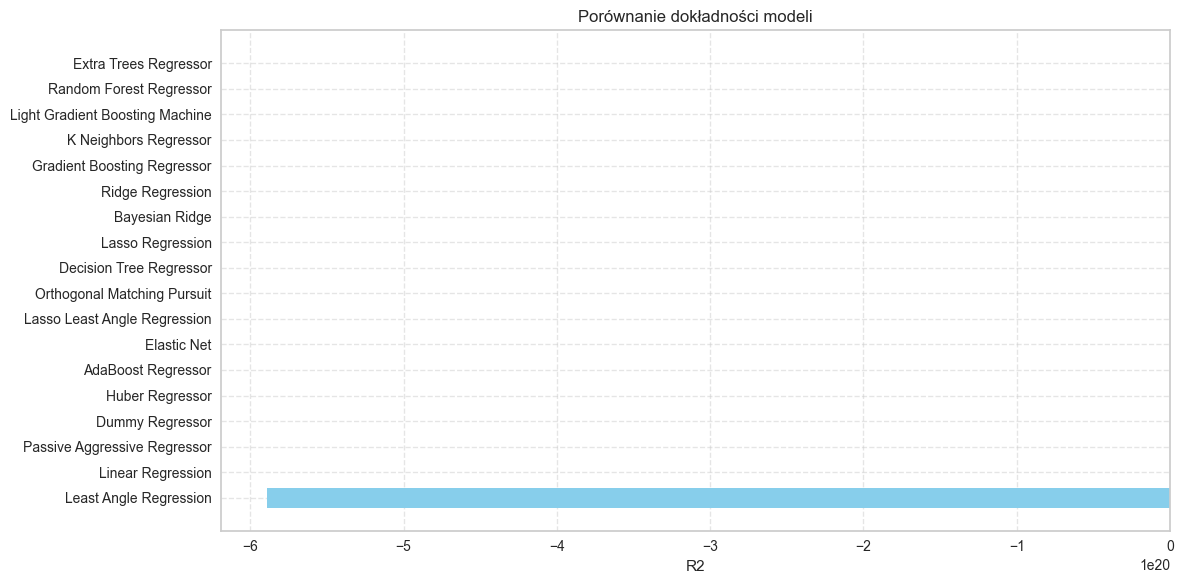

In [68]:
plt.figure(figsize=(12, 6))
plt.barh(transformed_metrics_df['Model'], transformed_metrics_df['R2'], color='skyblue')
plt.xlabel('R2')
plt.title('Porównanie dokładności modeli')
plt.gca().invert_yaxis()  # najlepszy model na górze
plt.grid(True, linestyle='--', alpha=0.5)
plt.tight_layout()
plt.show()

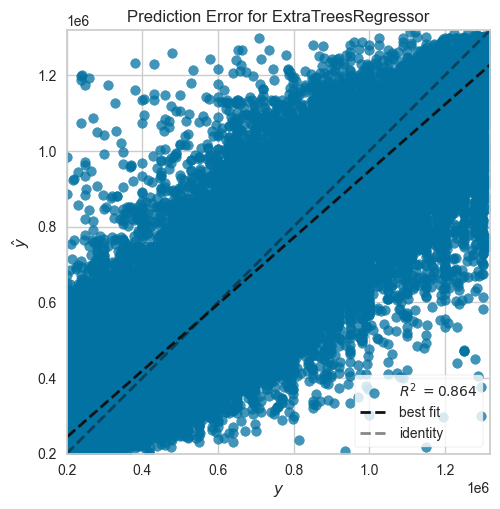

In [69]:
transformed_exp.plot_model(best_transformed_model, plot='error')

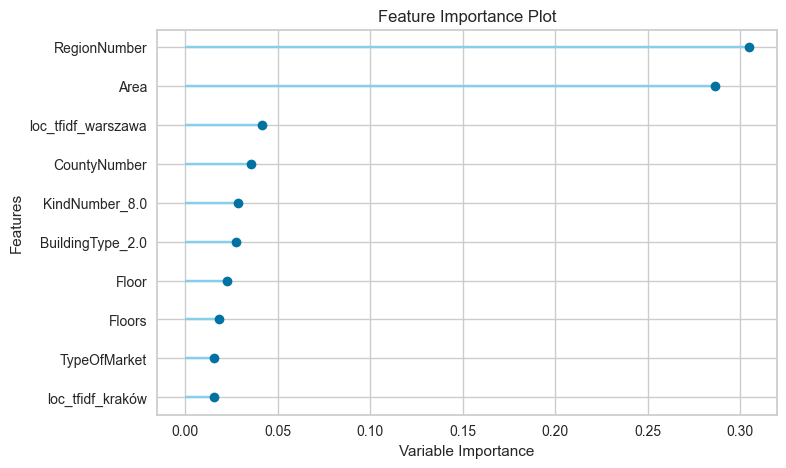

In [70]:
transformed_exp.plot_model(best_transformed_model, plot='feature')

In [71]:
tuned_model = transformed_exp.tune_model(best_transformed_model, n_iter=3, optimize='R2',choose_better=True)

,MAE,MSE,RMSE,R2,RMSLE,MAPE
Fold,,,,,,
0,183127.3755,51885219404.4413,227783.2729,0.0235,0.4193,0.3949
1,183746.8936,52154317752.1573,228373.1984,0.0212,0.4200,0.3954
2,182745.7329,51743896069.4327,227472.8469,0.0213,0.4180,0.3929
3,183055.1967,51838519154.5924,227680.7395,0.0215,0.4187,0.3942
4,182379.6214,51467809070.2516,226865.1782,0.0213,0.4182,0.3937
5,183504.1733,52241365806.2238,228563.7019,0.0211,0.4184,0.3926
6,181619.2013,51136930438.6033,226134.7617,0.0216,0.4179,0.3930
7,182622.3348,51696642370.0001,227368.9565,0.0211,0.4180,0.3928
8,183463.5414,52150854965.5245,228365.6169,0.0212,0.4188,0.3932


Fitting 10 folds for each of 3 candidates, totalling 30 fits
Original model was better than the tuned model, hence it will be returned. NOTE: The display metrics are for the tuned model (not the original one).


In [ ]:
#RF nie posiada parametru tuned_model - pominąć w przypadku rf
#tuned_best_models = [best_transformed_model.tune_model(m, optimize='R2') for m in tuned_model]

In [ ]:
# pominąć dla rf
#best_model = transformed_exp.compare_models([tuned_best_models, tuned_model],choose_better=True)

In [72]:
best_model = transformed_exp.compare_models(tuned_model, sort='R2')

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE,TT (Sec)
30,Decision Tree Regressor,69487.1856,12722228429.7610,112791.8395,0.7597,0.2016,0.1338,14.5430
9,Decision Tree Regressor,69528.8029,12743801542.5754,112884.4026,0.7593,0.2022,0.1341,15.6380
15,Decision Tree Regressor,69575.0781,12745544068.8730,112893.5113,0.7593,0.2020,0.1342,15.4800
37,Decision Tree Regressor,69598.9362,12761072078.2392,112961.9816,0.7590,0.2021,0.1342,15.3660
56,Decision Tree Regressor,69552.4272,12762049999.9813,112965.1137,0.7590,0.2018,0.1340,14.9200
98,Decision Tree Regressor,69600.5762,12757284968.6722,112946.0261,0.7590,0.2020,0.1342,15.5930
87,Decision Tree Regressor,69534.1352,12765638997.3563,112982.4202,0.7589,0.2019,0.1340,15.0290
62,Decision Tree Regressor,69645.2326,12770418009.9877,113003.8624,0.7588,0.2019,0.1341,15.5020
67,Decision Tree Regressor,69530.2499,12771205577.0861,113005.7112,0.7588,0.2019,0.1339,14.7660
46,Decision Tree Regressor,69545.1234,12777466693.5944,113034.2751,0.7587,0.2022,0.1341,15.2270


In [73]:
transformed_exp.predict_model(tuned_model)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,53186.1391,7159911367.7350,84616.2595,0.8637,0.1536,0.1037


,Area,NumberOfRooms,BuiltYear,Type,BuildingType,BuildingCondition,OfferFrom,Floor,Floors,TypeOfMarket,...,loc_tfidf_żniński,loc_tfidf_żoliborz,loc_tfidf_żory,loc_tfidf_żukowo,loc_tfidf_żwirki,loc_tfidf_żyrardowski,loc_tfidf_żyrardów,loc_tfidf_żywiecki,Price,prediction_label
841459,48.029999,3.0,2022-01-01,Mieszkania,Blok,NaN,Osoba prywatna,2.0,3.0,Pierwotny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,610000.0,606481.950000
926075,50.500000,2.0,NaT,Mieszkania,Blok,NaN,Osoba prywatna,4.0,NaN,Wtórny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280000.0,270370.000000
585042,58.000000,3.0,NaT,Mieszkania,Blok,NaN,Osoba prywatna,1.0,NaN,Wtórny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,522000.0,610500.000000
1091053,40.259998,2.0,2025-01-01,Mieszkania,NaN,DEVELOPER_STATE,Agencja,4.0,4.0,Pierwotny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,477200.0,500174.356667
1005631,44.000000,2.0,2021-01-01,Mieszkania,Apartamentowiec,NaN,Agencja,2.0,4.0,Wtórny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,955544.0,897823.255938
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1077875,48.450001,2.0,2025-01-01,Mieszkania,Blok,DEVELOPER_STATE,Agencja,2.0,NaN,Pierwotny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,505608.0,502891.893125
882178,62.169998,4.0,2026-01-01,Mieszkania,Blok,NaN,Agencja,4.0,6.0,Pierwotny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,657264.5,661173.932500
270266,53.340000,3.0,2023-01-01,Mieszkania,Blok,NaN,Agencja,1.0,1.0,Wtórny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,579000.0,521396.000000
770544,56.630001,3.0,NaT,Mieszkania,Apartamentowiec,NaN,Agencja,NaN,NaN,Pierwotny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,509670.0,509495.670000


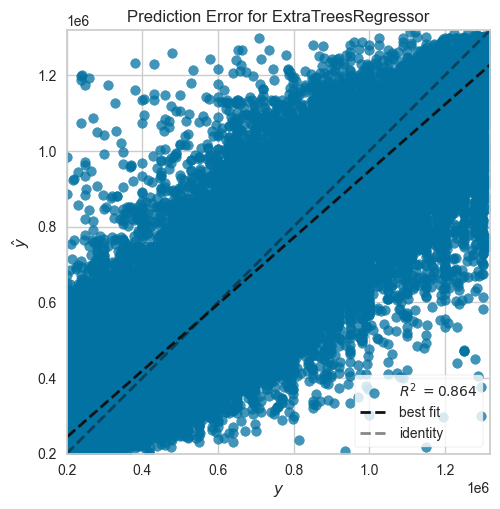

In [74]:
transformed_exp.plot_model(tuned_model, plot='error')

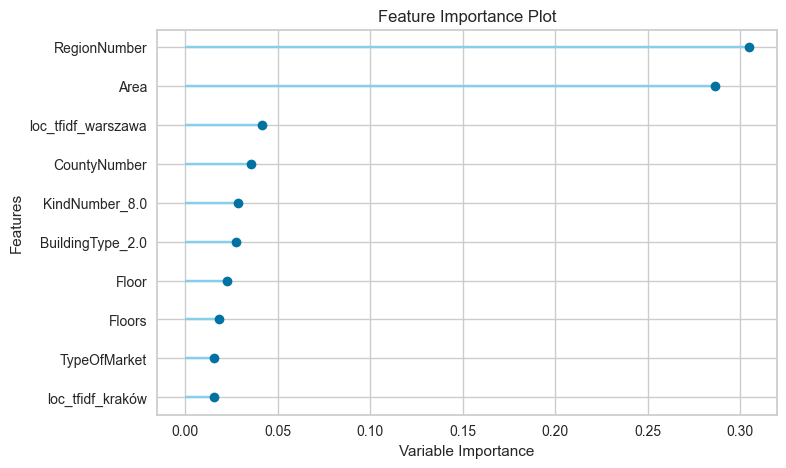

In [75]:
transformed_exp.plot_model(tuned_model, plot='feature')

In [76]:
transformed_exp.predict_model(tuned_model).head(10)

,Model,MAE,MSE,RMSE,R2,RMSLE,MAPE
0,Extra Trees Regressor,53186.1391,7159911367.7350,84616.2595,0.8637,0.1536,0.1037


,Area,NumberOfRooms,BuiltYear,Type,BuildingType,BuildingCondition,OfferFrom,Floor,Floors,TypeOfMarket,...,loc_tfidf_żniński,loc_tfidf_żoliborz,loc_tfidf_żory,loc_tfidf_żukowo,loc_tfidf_żwirki,loc_tfidf_żyrardowski,loc_tfidf_żyrardów,loc_tfidf_żywiecki,Price,prediction_label
841459,48.029999,3.0,2022-01-01,Mieszkania,Blok,NaN,Osoba prywatna,2.0,3.0,Pierwotny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,610000.0,606481.950000
926075,50.500000,2.0,NaT,Mieszkania,Blok,NaN,Osoba prywatna,4.0,NaN,Wtórny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,280000.0,270370.000000
585042,58.000000,3.0,NaT,Mieszkania,Blok,NaN,Osoba prywatna,1.0,NaN,Wtórny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,522000.0,610500.000000
1091053,40.259998,2.0,2025-01-01,Mieszkania,NaN,DEVELOPER_STATE,Agencja,4.0,4.0,Pierwotny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,477200.0,500174.356667
1005631,44.000000,2.0,2021-01-01,Mieszkania,Apartamentowiec,NaN,Agencja,2.0,4.0,Wtórny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,955544.0,897823.255938
612738,40.290001,2.0,2024-01-01,Mieszkania,Blok,NaN,Agencja,1.0,3.0,Pierwotny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,680901.0,682528.790000
724472,55.860001,3.0,2018-01-01,Mieszkania,Pozostałe,NaN,Osoba prywatna,0.0,NaN,Wtórny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,649000.0,620982.550000
1122028,61.919998,4.0,2025-01-01,Mieszkania,Blok,DEVELOPER_STATE,Agencja,4.0,5.0,Pierwotny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,544896.0,536370.270000
297267,51.000000,2.0,1989-01-01,Mieszkania,Blok,NaN,Agencja,4.0,NaN,Wtórny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,420000.0,404773.000000
462478,47.169998,2.0,NaT,Mieszkania,Apartamentowiec,NaN,Agencja,2.0,5.0,Pierwotny,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,580191.0,586521.425000


In [77]:
best_final_model = transformed_exp.finalize_model(tuned_model, experiment_custom_tags={"step": "final"})
best_final_model

Pipeline(memory=Memory(location=None),
         steps=[('date_feature_extractor',
                 TransformerWrapper(include=['BuiltYear'],
                                    transformer=ExtractDateTimeFeatures())),
                ('numerical_imputer',
                 TransformerWrapper(include=['Area', 'NumberOfRooms', 'Floor',
                                             'Floors', 'CommunityScore'],
                                    transformer=SimpleImputer())),
                ('categorical_imputer',
                 TransformerWrapper(include=['BuildingT...
                                                              use_cat_names=True))),
                ('rest_encoding',
                 TransformerWrapper(include=['OwnerType', 'CountyNumber',
                                             'RegionNumber'],
                                    transformer=TargetEncoder(cols=['OwnerType',
                                                                    'CountyNumber',
                                                                    'RegionNumber'],
                                                              handle_missing='return_nan'))),
                ('clean_column_names',
                 TransformerWrapper(transformer=CleanColumnNames())),
                ('actual_estimator',
                 ExtraTreesRegressor(n_jobs=-1, random_state=123))])

In [78]:
transformed_exp.save_model(best_final_model, '0_full-basic-model')

Transformation Pipeline and Model Successfully Saved


(Pipeline(memory=Memory(location=None),
          steps=[('date_feature_extractor',
                  TransformerWrapper(include=['BuiltYear'],
                                     transformer=ExtractDateTimeFeatures())),
                 ('numerical_imputer',
                  TransformerWrapper(include=['Area', 'NumberOfRooms', 'Floor',
                                              'Floors', 'CommunityScore'],
                                     transformer=SimpleImputer())),
                 ('categorical_imputer',
                  TransformerWrapper(include=['BuildingT...
                                                               use_cat_names=True))),
                 ('rest_encoding',
                  TransformerWrapper(include=['OwnerType', 'CountyNumber',
                                              'RegionNumber'],
                                     transformer=TargetEncoder(cols=['OwnerType',
                                                                     'Coun

In [79]:
transformed_exp.predict_model(best_final_model, data=holdout_df)
predict_holdout_df = transformed_exp.pull()

KeyError: "['loc_tfidf_11', 'loc_tfidf_adama', 'loc_tfidf_al', 'loc_tfidf_aleja', 'loc_tfidf_aleje', 'loc_tfidf_aleksandra', 'loc_tfidf_aleksandrowski', 'loc_tfidf_aleksandrów', 'loc_tfidf_andersa', 'loc_tfidf_andrychów', 'loc_tfidf_andrzeja', 'loc_tfidf_antoniego', 'loc_tfidf_antoniuk', 'loc_tfidf_armii', 'loc_tfidf_augusta', 'loc_tfidf_augustowski', 'loc_tfidf_augustów', 'loc_tfidf_azory', 'loc_tfidf_banacha', 'loc_tfidf_bartoszyce', 'loc_tfidf_bartoszycki', 'loc_tfidf_batorego', 'loc_tfidf_bałtycka', 'loc_tfidf_bałuty', 'loc_tfidf_bema', 'loc_tfidf_bemowo', 'loc_tfidf_bełchatowski', 'loc_tfidf_bełchatów', 'loc_tfidf_biała', 'loc_tfidf_białogard', 'loc_tfidf_białogardzki', 'loc_tfidf_białostocki', 'loc_tfidf_białostoczek', 'loc_tfidf_białołęka', 'loc_tfidf_biały', 'loc_tfidf_białystok', 'loc_tfidf_bielany', 'loc_tfidf_bielawa', 'loc_tfidf_bielawy', 'loc_tfidf_bielski', 'loc_tfidf_bielsko', 'loc_tfidf_bieńczyce', 'loc_tfidf_bieżanów', 'loc_tfidf_blizanowicka', 'loc_tfidf_bocheński', 'loc_tfidf_bochnia', 'loc_tfidf_bocianowo', 'loc_tfidf_boczna', 'loc_tfidf_bogucice', 'loc_tfidf_boguszów', 'loc_tfidf_bohaterów', 'loc_tfidf_bojary', 'loc_tfidf_bolesława', 'loc_tfidf_bolesławiec', 'loc_tfidf_bolesławiecki', 'loc_tfidf_bolszewo', 'loc_tfidf_borek', 'loc_tfidf_borkowska', 'loc_tfidf_borne', 'loc_tfidf_braniewski', 'loc_tfidf_brochów', 'loc_tfidf_brodnica', 'loc_tfidf_brodnicki', 'loc_tfidf_broniewskiego', 'loc_tfidf_bronowice', 'loc_tfidf_brwinów', 'loc_tfidf_brzeg', 'loc_tfidf_brzeski', 'loc_tfidf_brzeźno', 'loc_tfidf_bródno', 'loc_tfidf_bunscha', 'loc_tfidf_buski', 'loc_tfidf_busko', 'loc_tfidf_bułgaria', 'loc_tfidf_bydgoski', 'loc_tfidf_bydgoszcz', 'loc_tfidf_bytom', 'loc_tfidf_bytowski', 'loc_tfidf_będzin', 'loc_tfidf_będziński', 'loc_tfidf_błonie', 'loc_tfidf_cassino', 'loc_tfidf_centrum', 'loc_tfidf_chełm', 'loc_tfidf_chełmińska', 'loc_tfidf_chełmińskie', 'loc_tfidf_chodkiewicza', 'loc_tfidf_chodzieski', 'loc_tfidf_chojnice', 'loc_tfidf_chojnicki', 'loc_tfidf_chojny', 'loc_tfidf_chopina', 'loc_tfidf_choroszcz', 'loc_tfidf_chorzów', 'loc_tfidf_choszczeński', 'loc_tfidf_chrobrego', 'loc_tfidf_chrzanowski', 'loc_tfidf_chrzanów', 'loc_tfidf_chwarzno', 'loc_tfidf_chylonia', 'loc_tfidf_chłopskich', 'loc_tfidf_ciechanowski', 'loc_tfidf_ciechanów', 'loc_tfidf_ciechocinek', 'loc_tfidf_cieszyn', 'loc_tfidf_cieszyński', 'loc_tfidf_curie', 'loc_tfidf_czarnkowsko', 'loc_tfidf_czechowice', 'loc_tfidf_czeladź', 'loc_tfidf_czerwony', 'loc_tfidf_czesława', 'loc_tfidf_czyżkówko', 'loc_tfidf_czyżyny', 'loc_tfidf_częstochowa', 'loc_tfidf_częstochowski', 'loc_tfidf_człuchowski', 'loc_tfidf_darłowo', 'loc_tfidf_daszyńskiego', 'loc_tfidf_dmowskiego', 'loc_tfidf_do', 'loc_tfidf_dobra', 'loc_tfidf_dolne', 'loc_tfidf_dolnośląskie', 'loc_tfidf_dolny', 'loc_tfidf_dopiewo', 'loc_tfidf_dr', 'loc_tfidf_drabinianka', 'loc_tfidf_drawski', 'loc_tfidf_duchacka', 'loc_tfidf_dworcowa', 'loc_tfidf_dworska', 'loc_tfidf_dwór', 'loc_tfidf_dylewskiego', 'loc_tfidf_dywizjonu', 'loc_tfidf_działdowski', 'loc_tfidf_dziedzice', 'loc_tfidf_dzierżoniowski', 'loc_tfidf_dzierżoniów', 'loc_tfidf_dziesiąta', 'loc_tfidf_dziwnów', 'loc_tfidf_dąb', 'loc_tfidf_dąbie', 'loc_tfidf_dąbrowa', 'loc_tfidf_dąbrowskiego', 'loc_tfidf_dąbrówka', 'loc_tfidf_dębica', 'loc_tfidf_dębicki', 'loc_tfidf_dębniki', 'loc_tfidf_dębowa', 'loc_tfidf_długa', 'loc_tfidf_długołęka', 'loc_tfidf_edwarda', 'loc_tfidf_elbląg', 'loc_tfidf_elbląski', 'loc_tfidf_eugeniusza', 'loc_tfidf_ełcki', 'loc_tfidf_ełk', 'loc_tfidf_fabryczna', 'loc_tfidf_falenica', 'loc_tfidf_fordon', 'loc_tfidf_franciszka', 'loc_tfidf_fryderyka', 'loc_tfidf_gabriela', 'loc_tfidf_gaj', 'loc_tfidf_gdańsk', 'loc_tfidf_gdańska', 'loc_tfidf_gdański', 'loc_tfidf_gdynia', 'loc_tfidf_gen', 'loc_tfidf_generała', 'loc_tfidf_giżycki', 'loc_tfidf_giżycko', 'loc_tfidf_gliwice', 'loc_tfidf_gliwicki', 'loc_tfidf_gniezno', 'loc_tfidf_gnieźnieńska', 'loc_tfidf_gnieźnieński', 'loc_tfidf_gocław', 'loc_tfidf_goleniowski', 'loc_tfidf_goleniów', 'loc_tfidf_gorce', 'loc_tfidf_gorzowski', 'loc_tfidf_gorzów', 'loc_tfidf_gostyński', 'loc_tfidf_grabiszyn', 'loc_tfidf_grabówek', 'loc_tfidf_graniczna', 'loc_tfidf_grochów', 'loc_tfidf_grodzisk', 'loc_tfidf_grodziski', 'loc_tfidf_grudziądz', 'loc_tfidf_grunwald', 'loc_tfidf_grunwaldzka', 'loc_tfidf_gryfice', 'loc_tfidf_gryficki', 'loc_tfidf_gryfino', 'loc_tfidf_gryfiński', 'loc_tfidf_grzegórzki', 'loc_tfidf_grójec', 'loc_tfidf_grójecki', 'loc_tfidf_guderskiego', 'loc_tfidf_gumieńce', 'loc_tfidf_gustawa', 'loc_tfidf_góra', 'loc_tfidf_górce', 'loc_tfidf_górczyn', 'loc_tfidf_górka', 'loc_tfidf_górna', 'loc_tfidf_górne', 'loc_tfidf_górnicza', 'loc_tfidf_góry', 'loc_tfidf_górzyskowo', 'loc_tfidf_głogowski', 'loc_tfidf_głogów', 'loc_tfidf_główna', 'loc_tfidf_hallera', 'loc_tfidf_henryka', 'loc_tfidf_herbsta', 'loc_tfidf_heyki', 'loc_tfidf_hiszpania', 'loc_tfidf_huby', 'loc_tfidf_huta', 'loc_tfidf_ignacego', 'loc_tfidf_ii', 'loc_tfidf_iii', 'loc_tfidf_im', 'loc_tfidf_inne', 'loc_tfidf_inowrocław', 'loc_tfidf_inowrocławski', 'loc_tfidf_iława', 'loc_tfidf_iławski', 'loc_tfidf_jabłonna', 'loc_tfidf_jadwigi', 'loc_tfidf_jagiellońska', 'loc_tfidf_jagiełły', 'loc_tfidf_jagodno', 'loc_tfidf_jana', 'loc_tfidf_janickiego', 'loc_tfidf_janusza', 'loc_tfidf_jarocin', 'loc_tfidf_jarociński', 'loc_tfidf_jarosław', 'loc_tfidf_jarosława', 'loc_tfidf_jarosławski', 'loc_tfidf_jasielska', 'loc_tfidf_jasielski', 'loc_tfidf_jasień', 'loc_tfidf_jasna', 'loc_tfidf_jastrzębia', 'loc_tfidf_jastrzębie', 'loc_tfidf_jasło', 'loc_tfidf_jaworski', 'loc_tfidf_jaworzno', 'loc_tfidf_jedności', 'loc_tfidf_jelcz', 'loc_tfidf_jelenia', 'loc_tfidf_jerzego', 'loc_tfidf_jeziorna', 'loc_tfidf_jeżyce', 'loc_tfidf_juliana', 'loc_tfidf_juliusza', 'loc_tfidf_junikowo', 'loc_tfidf_józefa', 'loc_tfidf_józefosław', 'loc_tfidf_jędrzejowski', 'loc_tfidf_kack', 'loc_tfidf_kalinowszczyzna', 'loc_tfidf_kalisz', 'loc_tfidf_kalwaria', 'loc_tfidf_kamienna', 'loc_tfidf_kamiennogórski', 'loc_tfidf_kamień', 'loc_tfidf_kamieński', 'loc_tfidf_kamila', 'loc_tfidf_kapuściska', 'loc_tfidf_kardynała', 'loc_tfidf_karkonoska', 'loc_tfidf_karkonoski', 'loc_tfidf_karola', 'loc_tfidf_karpacz', 'loc_tfidf_kartuska', 'loc_tfidf_kartuski', 'loc_tfidf_karłowice', 'loc_tfidf_kasztanowa', 'loc_tfidf_katowice', 'loc_tfidf_katowicka', 'loc_tfidf_kazimierza', 'loc_tfidf_kielce', 'loc_tfidf_kielecki', 'loc_tfidf_kiełczów', 'loc_tfidf_kilińskiego', 'loc_tfidf_klecina', 'loc_tfidf_kleczków', 'loc_tfidf_klemensa', 'loc_tfidf_kleszczewo', 'loc_tfidf_klimontowska', 'loc_tfidf_klimontów', 'loc_tfidf_klimzowiec', 'loc_tfidf_klonowa', 'loc_tfidf_kluczbork', 'loc_tfidf_kluczborski', 'loc_tfidf_knurów', 'loc_tfidf_kobierzyce', 'loc_tfidf_kobyłka', 'loc_tfidf_kochanowskiego', 'loc_tfidf_kolbudy', 'loc_tfidf_kolejowa', 'loc_tfidf_kolonia', 'loc_tfidf_kolski', 'loc_tfidf_komorniki', 'loc_tfidf_konin', 'loc_tfidf_koniński', 'loc_tfidf_konopnickiej', 'loc_tfidf_konrada', 'loc_tfidf_konstantego', 'loc_tfidf_konstytucji', 'loc_tfidf_kopernika', 'loc_tfidf_korfantego', 'loc_tfidf_kosakowo', 'loc_tfidf_kostrzyn', 'loc_tfidf_kosynierów', 'loc_tfidf_koszalin', 'loc_tfidf_koszaliński', 'loc_tfidf_koszutka', 'loc_tfidf_kowale', 'loc_tfidf_kozielski', 'loc_tfidf_koziny', 'loc_tfidf_kołbaskowo', 'loc_tfidf_koło', 'loc_tfidf_kołobrzeg', 'loc_tfidf_kołobrzeski', 'loc_tfidf_kołodzieja', 'loc_tfidf_kołłątaja', 'loc_tfidf_kościan', 'loc_tfidf_kościański', 'loc_tfidf_kościelisko', 'loc_tfidf_kościelna', 'loc_tfidf_kościerski', 'loc_tfidf_kościerzyna', 'loc_tfidf_kościuszki', 'loc_tfidf_koźle', 'loc_tfidf_krajowej', 'loc_tfidf_krakowska', 'loc_tfidf_krakowski', 'loc_tfidf_kraków', 'loc_tfidf_krapkowicki', 'loc_tfidf_krasińskiego', 'loc_tfidf_kraszewskiego', 'loc_tfidf_kraśnicki', 'loc_tfidf_kraśnik', 'loc_tfidf_krosno', 'loc_tfidf_krotoszyński', 'loc_tfidf_krowodrza', 'loc_tfidf_krośnieński', 'loc_tfidf_krynica', 'loc_tfidf_krzyki', 'loc_tfidf_krzymów', 'loc_tfidf_krzysztofa', 'loc_tfidf_królowej', 'loc_tfidf_ks', 'loc_tfidf_księcia', 'loc_tfidf_księdza', 'loc_tfidf_kujawski', 'loc_tfidf_kujawsko', 'loc_tfidf_kutno', 'loc_tfidf_kutnowski', 'loc_tfidf_kwiatkowskiego', 'loc_tfidf_kwidzyn', 'loc_tfidf_kwidzyński', 'loc_tfidf_kórnik', 'loc_tfidf_kąty', 'loc_tfidf_kędzierzyn', 'loc_tfidf_kędzierzyńsko', 'loc_tfidf_kępa', 'loc_tfidf_kępiński', 'loc_tfidf_kętrzyn', 'loc_tfidf_kętrzyński', 'loc_tfidf_kłodzki', 'loc_tfidf_kłodzko', 'loc_tfidf_las', 'loc_tfidf_laskowice', 'loc_tfidf_lecia', 'loc_tfidf_legionowo', 'loc_tfidf_legionowski', 'loc_tfidf_legionów', 'loc_tfidf_legnica', 'loc_tfidf_legnicki', 'loc_tfidf_leona', 'loc_tfidf_leopolda', 'loc_tfidf_leszczyński', 'loc_tfidf_leszno', 'loc_tfidf_lesznowola', 'loc_tfidf_letnica', 'loc_tfidf_leśna', 'loc_tfidf_leśne', 'loc_tfidf_leśnica', 'loc_tfidf_ligota', 'loc_tfidf_lipa', 'loc_tfidf_lipowa', 'loc_tfidf_listopada', 'loc_tfidf_lothara', 'loc_tfidf_lubań', 'loc_tfidf_lubański', 'loc_tfidf_lubelski', 'loc_tfidf_lubelskie', 'loc_tfidf_lubelskiej', 'loc_tfidf_lubin', 'loc_tfidf_lubiński', 'loc_tfidf_lublin', 'loc_tfidf_luboń', 'loc_tfidf_lubuskie', 'loc_tfidf_ludwika', 'loc_tfidf_lwowska', 'loc_tfidf_lwówecki', 'loc_tfidf_lębork', 'loc_tfidf_lęborski', 'loc_tfidf_macieja', 'loc_tfidf_maja', 'loc_tfidf_malbork', 'loc_tfidf_malborski', 'loc_tfidf_marcina', 'loc_tfidf_mariana', 'loc_tfidf_marii', 'loc_tfidf_marki', 'loc_tfidf_marsz', 'loc_tfidf_marszałka', 'loc_tfidf_marysin', 'loc_tfidf_matejki', 'loc_tfidf_mazowiecka', 'loc_tfidf_mazowiecki', 'loc_tfidf_mazowieckie', 'loc_tfidf_mazurskie', 'loc_tfidf_mała', 'loc_tfidf_małe', 'loc_tfidf_małopolski', 'loc_tfidf_małopolskie', 'loc_tfidf_mały', 'loc_tfidf_maślice', 'loc_tfidf_miasto', 'loc_tfidf_michała', 'loc_tfidf_michałkowice', 'loc_tfidf_mickiewicza', 'loc_tfidf_mieczysława', 'loc_tfidf_mielec', 'loc_tfidf_mielecki', 'loc_tfidf_mielno', 'loc_tfidf_mieszka', 'loc_tfidf_mikołaja', 'loc_tfidf_mikołowski', 'loc_tfidf_mikołów', 'loc_tfidf_mirów', 'loc_tfidf_mistrzejowice', 'loc_tfidf_międzyrzecki', 'loc_tfidf_międzyzdroje', 'loc_tfidf_miękinia', 'loc_tfidf_mińsk', 'loc_tfidf_miński', 'loc_tfidf_mjr', 'loc_tfidf_mokotów', 'loc_tfidf_mokre', 'loc_tfidf_moniuszki', 'loc_tfidf_monte', 'loc_tfidf_morcinka', 'loc_tfidf_morska', 'loc_tfidf_morskie', 'loc_tfidf_mrągowo', 'loc_tfidf_mrągowski', 'loc_tfidf_muchobór', 'loc_tfidf_muszlowa', 'loc_tfidf_mysłowice', 'loc_tfidf_myślenice', 'loc_tfidf_myślenicki', 'loc_tfidf_myśliborski', 'loc_tfidf_myśliwska', 'loc_tfidf_mława', 'loc_tfidf_mławski', 'loc_tfidf_młynów', 'loc_tfidf_na', 'loc_tfidf_nad', 'loc_tfidf_nakielski', 'loc_tfidf_nakło', 'loc_tfidf_namysłowski', 'loc_tfidf_namysłów', 'loc_tfidf_naramowice', 'loc_tfidf_narodowa', 'loc_tfidf_narodowej', 'loc_tfidf_narutowicza', 'loc_tfidf_niebuszewo', 'loc_tfidf_niepodległości', 'loc_tfidf_niepołomice', 'loc_tfidf_notecią', 'loc_tfidf_nowa', 'loc_tfidf_nowe', 'loc_tfidf_nowodworski', 'loc_tfidf_nowodwory', 'loc_tfidf_nowosolski', 'loc_tfidf_nowosądecki', 'loc_tfidf_nowotarski', 'loc_tfidf_nowotomyski', 'loc_tfidf_nowy', 'loc_tfidf_nysa', 'loc_tfidf_nyski', 'loc_tfidf_obornicki', 'loc_tfidf_oborniki', 'loc_tfidf_obrońców', 'loc_tfidf_obłuże', 'loc_tfidf_ochota', 'loc_tfidf_odległa', 'loc_tfidf_odrzańskie', 'loc_tfidf_ogrodowa', 'loc_tfidf_ogrody', 'loc_tfidf_okole', 'loc_tfidf_okrzei', 'loc_tfidf_oksywie', 'loc_tfidf_olecki', 'loc_tfidf_olecko', 'loc_tfidf_oleśnica', 'loc_tfidf_oleśnicki', 'loc_tfidf_oliwa', 'loc_tfidf_olkuski', 'loc_tfidf_olkusz', 'loc_tfidf_olsztyn', 'loc_tfidf_olsztyński', 'loc_tfidf_opole', 'loc_tfidf_opolska', 'loc_tfidf_opolski', 'loc_tfidf_opolskie', 'loc_tfidf_orzeszkowej', 'loc_tfidf_os', 'loc_tfidf_osiedle', 'loc_tfidf_osielsko', 'loc_tfidf_osowa', 'loc_tfidf_ostrowiec', 'loc_tfidf_ostrowiecki', 'loc_tfidf_ostrowski', 'loc_tfidf_ostrołęka', 'loc_tfidf_ostróda', 'loc_tfidf_ostródzki', 'loc_tfidf_ostrów', 'loc_tfidf_otwock', 'loc_tfidf_otwocki', 'loc_tfidf_oława', 'loc_tfidf_oławski', 'loc_tfidf_ołtaszyn', 'loc_tfidf_oświęcim', 'loc_tfidf_oświęcimski', 'loc_tfidf_ożarów', 'loc_tfidf_pabianice', 'loc_tfidf_pabianicka', 'loc_tfidf_pabianicki', 'loc_tfidf_paderewskiego', 'loc_tfidf_panien', 'loc_tfidf_park', 'loc_tfidf_parkitka', 'loc_tfidf_partynice', 'loc_tfidf_partyzantów', 'loc_tfidf_pawła', 'loc_tfidf_piaseczno', 'loc_tfidf_piaseczyński', 'loc_tfidf_piaski', 'loc_tfidf_piaskowa', 'loc_tfidf_piasta', 'loc_tfidf_piastowska', 'loc_tfidf_piastów', 'loc_tfidf_piekary', 'loc_tfidf_pilski', 'loc_tfidf_piotra', 'loc_tfidf_piotrkowska', 'loc_tfidf_piotrków', 'loc_tfidf_piotrowska', 'loc_tfidf_piski', 'loc_tfidf_piątkowo', 'loc_tfidf_piła', 'loc_tfidf_piłsudskiego', 'loc_tfidf_pl', 'loc_tfidf_plac', 'loc_tfidf_planty', 'loc_tfidf_plewiska', 'loc_tfidf_podgórze', 'loc_tfidf_podkarpackie', 'loc_tfidf_podlaska', 'loc_tfidf_podlaski', 'loc_tfidf_podlaskie', 'loc_tfidf_podolany', 'loc_tfidf_podzamcze', 'loc_tfidf_pogodno', 'loc_tfidf_pogoń', 'loc_tfidf_pogórze', 'loc_tfidf_pokoju', 'loc_tfidf_polanica', 'loc_tfidf_pole', 'loc_tfidf_polesie', 'loc_tfidf_police', 'loc_tfidf_policki', 'loc_tfidf_politechniki', 'loc_tfidf_polkowice', 'loc_tfidf_polkowicki', 'loc_tfidf_polna', 'loc_tfidf_polskich', 'loc_tfidf_polskiego', 'loc_tfidf_pomorska', 'loc_tfidf_pomorskie', 'loc_tfidf_pomorzany', 'loc_tfidf_ponikwoda', 'loc_tfidf_popiełuszki', 'loc_tfidf_poręba', 'loc_tfidf_posag', 'loc_tfidf_powstańców', 'loc_tfidf_poznań', 'loc_tfidf_poznańska', 'loc_tfidf_poznański', 'loc_tfidf_południe', 'loc_tfidf_praga', 'loc_tfidf_prof', 'loc_tfidf_prokocim', 'loc_tfidf_prudnicki', 'loc_tfidf_pruszcz', 'loc_tfidf_pruszkowski', 'loc_tfidf_pruszków', 'loc_tfidf_prymasa', 'loc_tfidf_przedmieście', 'loc_tfidf_przemysłowa', 'loc_tfidf_przemyśl', 'loc_tfidf_przybyszówka', 'loc_tfidf_przyjaźni', 'loc_tfidf_przymorze', 'loc_tfidf_prądnik', 'loc_tfidf_psie', 'loc_tfidf_pszczyna', 'loc_tfidf_pszczyński', 'loc_tfidf_puck', 'loc_tfidf_pucki', 'loc_tfidf_pułaskiego', 'loc_tfidf_puławski', 'loc_tfidf_puławy', 'loc_tfidf_pułku', 'loc_tfidf_pyrzycki', 'loc_tfidf_północ', 'loc_tfidf_pękowicka', 'loc_tfidf_płaszów', 'loc_tfidf_płk', 'loc_tfidf_płock', 'loc_tfidf_płońsk', 'loc_tfidf_płoński', 'loc_tfidf_raciborski', 'loc_tfidf_racibórz', 'loc_tfidf_racławicka', 'loc_tfidf_radogoszcz', 'loc_tfidf_radom', 'loc_tfidf_radomski', 'loc_tfidf_radomsko', 'loc_tfidf_radomszczański', 'loc_tfidf_radzymin', 'loc_tfidf_raków', 'loc_tfidf_rataje', 'loc_tfidf_reda', 'loc_tfidf_reja', 'loc_tfidf_rembertów', 'loc_tfidf_retkinia', 'loc_tfidf_rewal', 'loc_tfidf_reymonta', 'loc_tfidf_rokicie', 'loc_tfidf_rokietnica', 'loc_tfidf_rokitki', 'loc_tfidf_romana', 'loc_tfidf_romualda', 'loc_tfidf_rondo', 'loc_tfidf_rotmanka', 'loc_tfidf_roweckiego', 'loc_tfidf_rubinkowo', 'loc_tfidf_ruczaj', 'loc_tfidf_ruda', 'loc_tfidf_rumia', 'loc_tfidf_rury', 'loc_tfidf_rybnik', 'loc_tfidf_rydlówka', 'loc_tfidf_rzeczenica', 'loc_tfidf_rzeszowski', 'loc_tfidf_rzeszów', 'loc_tfidf_sady', 'loc_tfidf_sandomierski', 'loc_tfidf_sarbinowo', 'loc_tfidf_saska', 'loc_tfidf_siechnice', 'loc_tfidf_siedlce', 'loc_tfidf_sielawy', 'loc_tfidf_sielce', 'loc_tfidf_sielec', 'loc_tfidf_siemianowice', 'loc_tfidf_sienkiewicza', 'loc_tfidf_sieradz', 'loc_tfidf_sieradzki', 'loc_tfidf_sierpnia', 'loc_tfidf_siewierz', 'loc_tfidf_sikorskiego', 'loc_tfidf_skargi', 'loc_tfidf_skarpie', 'loc_tfidf_skarżyski', 'loc_tfidf_skarżysko', 'loc_tfidf_skawina', 'loc_tfidf_skierniewice', 'loc_tfidf_skorosze', 'loc_tfidf_skwer', 'loc_tfidf_skłodowskiej', 'loc_tfidf_sobieskiego', 'loc_tfidf_sochaczew', 'loc_tfidf_sochaczewski', 'loc_tfidf_solidarności', 'loc_tfidf_sopot', 'loc_tfidf_sosnowiec', 'loc_tfidf_sołtysowice', 'loc_tfidf_sportowa', 'loc_tfidf_spółdzielcza', 'loc_tfidf_srebrzyńska', 'loc_tfidf_stalowa', 'loc_tfidf_stalowowolski', 'loc_tfidf_stanisława', 'loc_tfidf_stara', 'loc_tfidf_starachowice', 'loc_tfidf_starachowicki', 'loc_tfidf_stare', 'loc_tfidf_stargard', 'loc_tfidf_stargardzki', 'loc_tfidf_starogard', 'loc_tfidf_starogardzki', 'loc_tfidf_starowiejska', 'loc_tfidf_starołęka', 'loc_tfidf_stary', 'loc_tfidf_staszica', 'loc_tfidf_staszowski', 'loc_tfidf_stawiguda', 'loc_tfidf_stefana', 'loc_tfidf_stegna', 'loc_tfidf_straszyn', 'loc_tfidf_strzelce', 'loc_tfidf_strzelców', 'loc_tfidf_strzelecki', 'loc_tfidf_strzeliński', 'loc_tfidf_stwosza', 'loc_tfidf_suchy', 'loc_tfidf_sulechów', 'loc_tfidf_sulinowo', 'loc_tfidf_suwałki', 'loc_tfidf_swarzędz', 'loc_tfidf_szafirowa', 'loc_tfidf_szamotulski', 'loc_tfidf_szamoty', 'loc_tfidf_szczecin', 'loc_tfidf_szczecinecki', 'loc_tfidf_szczecinek', 'loc_tfidf_szczecińska', 'loc_tfidf_szczepin', 'loc_tfidf_szczycieński', 'loc_tfidf_szczyrk', 'loc_tfidf_szczytno', 'loc_tfidf_szczęśliwice', 'loc_tfidf_szklarska', 'loc_tfidf_szkolna', 'loc_tfidf_szombierki', 'loc_tfidf_szpitalna', 'loc_tfidf_sztutowo', 'loc_tfidf_szwederowo', 'loc_tfidf_szydłówek', 'loc_tfidf_sól', 'loc_tfidf_sącz', 'loc_tfidf_sławieński', 'loc_tfidf_sławin', 'loc_tfidf_słocina', 'loc_tfidf_słoneczna', 'loc_tfidf_słowackiego', 'loc_tfidf_słubice', 'loc_tfidf_słubicki', 'loc_tfidf_słupsk', 'loc_tfidf_słupski', 'loc_tfidf_służew', 'loc_tfidf_służewiec', 'loc_tfidf_tadeusza', 'loc_tfidf_tarchomin', 'loc_tfidf_targ', 'loc_tfidf_targowa', 'loc_tfidf_targówek', 'loc_tfidf_tarnobrzeg', 'loc_tfidf_tarnogaj', 'loc_tfidf_tarnogórski', 'loc_tfidf_tarnowo', 'loc_tfidf_tarnowski', 'loc_tfidf_tarnowskie', 'loc_tfidf_tarnów', 'loc_tfidf_tatrzańska', 'loc_tfidf_tatrzański', 'loc_tfidf_tczew', 'loc_tfidf_tczewski', 'loc_tfidf_teofila', 'loc_tfidf_teofilów', 'loc_tfidf_tomaszowski', 'loc_tfidf_tomaszów', 'loc_tfidf_toruń', 'loc_tfidf_toruńska', 'loc_tfidf_toruński', 'loc_tfidf_traugutta', 'loc_tfidf_trybunalski', 'loc_tfidf_trzcianecki', 'loc_tfidf_trzebiatów', 'loc_tfidf_trzebnica', 'loc_tfidf_trzebnicki', 'loc_tfidf_tuwima', 'loc_tfidf_tychy', 'loc_tfidf_tysiąclecia', 'loc_tfidf_ujeścisko', 'loc_tfidf_ul', 'loc_tfidf_ulrychów', 'loc_tfidf_unii', 'loc_tfidf_urbanisty', 'loc_tfidf_ursus', 'loc_tfidf_ursynów', 'loc_tfidf_ustka', 'loc_tfidf_ustronie', 'loc_tfidf_ustroń', 'loc_tfidf_wadowice', 'loc_tfidf_wadowicka', 'loc_tfidf_wadowicki', 'loc_tfidf_wagrowska', 'loc_tfidf_walerego', 'loc_tfidf_warmińsko', 'loc_tfidf_warszawa', 'loc_tfidf_warszawska', 'loc_tfidf_warszawski', 'loc_tfidf_warszawy', 'loc_tfidf_warszewo', 'loc_tfidf_waryńskiego', 'loc_tfidf_wawer', 'loc_tfidf_wałbrzych', 'loc_tfidf_wałbrzyski', 'loc_tfidf_wałcz', 'loc_tfidf_wałecki', 'loc_tfidf_wejherowo', 'loc_tfidf_wejherowski', 'loc_tfidf_wesoła', 'loc_tfidf_westerplatte', 'loc_tfidf_wełnowiec', 'loc_tfidf_wiczlino', 'loc_tfidf_widzew', 'loc_tfidf_wiejska', 'loc_tfidf_wielicki', 'loc_tfidf_wieliczka', 'loc_tfidf_wielka', 'loc_tfidf_wielki', 'loc_tfidf_wielkie', 'loc_tfidf_wielkiego', 'loc_tfidf_wielkopolska', 'loc_tfidf_wielkopolski', 'loc_tfidf_wielkopolskie', 'loc_tfidf_wieluń', 'loc_tfidf_wieluński', 'loc_tfidf_wieniawa', 'loc_tfidf_wierzbno', 'loc_tfidf_wieś', 'loc_tfidf_wigury', 'loc_tfidf_wilanów', 'loc_tfidf_wilda', 'loc_tfidf_wileńska', 'loc_tfidf_wilkowice', 'loc_tfidf_wincentego', 'loc_tfidf_winogrady', 'loc_tfidf_wita', 'loc_tfidf_witolda', 'loc_tfidf_witomino', 'loc_tfidf_witosa', 'loc_tfidf_wodzisław', 'loc_tfidf_wodzisławski', 'loc_tfidf_wojciecha', 'loc_tfidf_wojska', 'loc_tfidf_wojszyce', 'loc_tfidf_wola', 'loc_tfidf_wolności', 'loc_tfidf_wołomin', 'loc_tfidf_wołomiński', 'loc_tfidf_wołowski', 'loc_tfidf_wołów', 'loc_tfidf_wrocław', 'loc_tfidf_wrocławska', 'loc_tfidf_wrocławski', 'loc_tfidf_wrocławskie', 'loc_tfidf_wrotków', 'loc_tfidf_wrzesiński', 'loc_tfidf_wrzeszcz', 'loc_tfidf_września', 'loc_tfidf_wrzosowiak', 'loc_tfidf_wrzosy', 'loc_tfidf_wybickiego', 'loc_tfidf_wysoka', 'loc_tfidf_wyspiańskiego', 'loc_tfidf_wyszkowski', 'loc_tfidf_wyszków', 'loc_tfidf_wyszyńskiego', 'loc_tfidf_wyzwolenia', 'loc_tfidf_wyżyny', 'loc_tfidf_wzgórze', 'loc_tfidf_wólczańska', 'loc_tfidf_wągrowiec', 'loc_tfidf_wągrowiecki', 'loc_tfidf_węgorzewski', 'loc_tfidf_władysława', 'loc_tfidf_władysławowo', 'loc_tfidf_włochy', 'loc_tfidf_włocławek', 'loc_tfidf_zabobrze', 'loc_tfidf_zabrska', 'loc_tfidf_zabrze', 'loc_tfidf_zabłocie', 'loc_tfidf_zachodni', 'loc_tfidf_zachodnia', 'loc_tfidf_zachodniopomorskie', 'loc_tfidf_zacisze', 'loc_tfidf_zagórze', 'loc_tfidf_zakopane', 'loc_tfidf_zalasewo', 'loc_tfidf_zalesie', 'loc_tfidf_zamość', 'loc_tfidf_zarzew', 'loc_tfidf_zawada', 'loc_tfidf_zawierciański', 'loc_tfidf_zawiercie', 'loc_tfidf_zdrowie', 'loc_tfidf_zdrój', 'loc_tfidf_zduńska', 'loc_tfidf_zduńskowolski', 'loc_tfidf_zgierski', 'loc_tfidf_zgierz', 'loc_tfidf_zgorzelec', 'loc_tfidf_zgorzelecki', 'loc_tfidf_zielona', 'loc_tfidf_zielonki', 'loc_tfidf_zielonogórski', 'loc_tfidf_zwycięska', 'loc_tfidf_zwycięstwa', 'loc_tfidf_zygmunta', 'loc_tfidf_ząbki', 'loc_tfidf_ząbkowicki', 'loc_tfidf_złota', 'loc_tfidf_złotowski', 'loc_tfidf_złotów', 'loc_tfidf_łagiewniki', 'loc_tfidf_łazarz', 'loc_tfidf_łańcucki', 'loc_tfidf_łańcut', 'loc_tfidf_łokietka', 'loc_tfidf_łomianki', 'loc_tfidf_łomża', 'loc_tfidf_łostowice', 'loc_tfidf_łukowski', 'loc_tfidf_łuków', 'loc_tfidf_łódzki', 'loc_tfidf_łódzkie', 'loc_tfidf_łódź', 'loc_tfidf_łęczna', 'loc_tfidf_łęczyński', 'loc_tfidf_łężyca', 'loc_tfidf_śląska', 'loc_tfidf_śląski', 'loc_tfidf_śląskich', 'loc_tfidf_śląskie', 'loc_tfidf_średzki', 'loc_tfidf_śrem', 'loc_tfidf_śremski', 'loc_tfidf_środa', 'loc_tfidf_środula', 'loc_tfidf_śródmieście', 'loc_tfidf_św', 'loc_tfidf_świat', 'loc_tfidf_świdnica', 'loc_tfidf_świdnicki', 'loc_tfidf_świdnik', 'loc_tfidf_świdwiński', 'loc_tfidf_świebodzice', 'loc_tfidf_świebodzin', 'loc_tfidf_świebodziński', 'loc_tfidf_świecie', 'loc_tfidf_świecki', 'loc_tfidf_świeradów', 'loc_tfidf_świnoujście', 'loc_tfidf_świętochłowice', 'loc_tfidf_świętokrzyski', 'loc_tfidf_świętokrzyskie', 'loc_tfidf_żagań', 'loc_tfidf_żagański', 'loc_tfidf_żarski', 'loc_tfidf_żary', 'loc_tfidf_żegrze', 'loc_tfidf_żerań', 'loc_tfidf_żeromskiego', 'loc_tfidf_żniński', 'loc_tfidf_żoliborz', 'loc_tfidf_żory', 'loc_tfidf_żukowo', 'loc_tfidf_żwirki', 'loc_tfidf_żyrardowski', 'loc_tfidf_żyrardów', 'loc_tfidf_żywiecki'] not in index"

In [ ]:
mlflow_exp = mlflow.get_experiment_by_name(MLFLOW_EXPERIMENT_NAME)
runs_df = mlflow.search_runs([mlflow_exp.experiment_id], order_by=["start_time DESC"])
run_id = runs_df['run_id'].values[0]
metrics = predict_holdout_df.drop(columns=["Model"]).to_dict(orient='records')[0]

with mlflow.start_run(run_id=run_id, nested=True):
    for key, value in metrics.items():
        mlflow.log_metric(key, value)

In [ ]:
#predictions = transformed_exp.predict_model(best_final_model)
holdout_predictions = transformed_exp.predict_model(best_final_model) # Zapisz wynik predykcji
display(holdout_predictions.head()) # Wyświetl kilka pierwszych predykcji

In [ ]:
#predicted_column = predict_holdout_df['prediction_label']
#print(predicted_column)
holdout_metrics_df = transformed_exp.pull() # Teraz pobierz metryki z tej predykcji
display(holdout_metrics_df)
predicted_column = holdout_predictions['prediction_label'] # Jeśli chcesz samą kolumnę predykcji
print(predicted_column)

In [ ]:
print(holdout_predictions[['prediction_label']].applymap('{:,.0f}'.format))

In [ ]:
df_last=holdout_predictions[['prediction_label','Price', ]].applymap('{:,.0f}'.format)

In [ ]:
df_last.to_csv('0_new_prices.csv')

In [ ]:
print(df_last.columns)

In [ ]:
print(df_last.head())

In [ ]:
df_last = df_last.reset_index()  
print(df_last.columns)  

In [ ]:
df_last.rename(columns={'index': 'SaleId'}, inplace=True)

In [ ]:
saleflats_df = pd.read_csv('sale_2024_0.csv')

In [ ]:
new_prices_df = pd.read_csv('0_new_prices.csv')

In [ ]:
print("saleflats_df.columns:", saleflats_df.columns.tolist())

In [ ]:
print("new_prices_df.columns:", new_prices_df.columns.tolist())

In [ ]:
new_prices_df = new_prices_df.rename(columns={'Unnamed: 0': 'SaleId', 'Price': 'NewPrice'})

In [ ]:
print("new_prices_df.columns:", new_prices_df.columns.tolist())

In [ ]:
print(new_prices_df.columns)

In [ ]:
print(saleflats_df.columns)

In [ ]:
merged_df = pd.merge(
    saleflats_df,
    new_prices_df[['SaleId', 'NewPrice']],
    left_on='SaleId',  # Kolumna w saleflats_df
    right_on='SaleId',  # Kolumna w new_prices_df
    how='left'
)

In [ ]:
merged_df

In [ ]:
# Krok 2: usuwanie dodatkowej kolumny klucza (opcjonalnie, bo mamy już 'SaleId')
#merged_df.drop(columns=['SaleID'], inplace=True)

# Krok 3: przestawienie kolumny 'NewPrice' obok 'Price'
cols = merged_df.columns.tolist()

# znajdź indeks kolumny 'Price'
price_index = cols.index('Price')

# usuń NewPrice z listy i dodaj ją zaraz po Price
cols.remove('NewPrice')
cols.insert(price_index + 1, 'NewPrice')

# ustaw nową kolejność kolumn
merged_df = merged_df[cols]

In [ ]:
merged_df

In [ ]:
merged_df[merged_df.duplicated()]

In [ ]:
prediction_df = merged_df.copy()

In [ ]:
from pycaret.regression import predict_model

In [ ]:
prediction_df['BuiltYear'] = pd.to_datetime(prediction_df['BuiltYear'], format='%Y', errors='coerce')

In [ ]:
prediction_df_clean = prediction_df.drop(columns=['Price'], errors='ignore')
predictions = predict_model(best_final_model, data=prediction_df_clean)

In [ ]:
predictions['RealPrice'] = prediction_df['Price']

In [ ]:
merged_df['PredictedPrice'] = predictions['prediction_label']

In [ ]:
predictions=predictions[['prediction_label',]].applymap('{:,.0f}'.format)

In [ ]:
# Przenieś kolumnę 'PredictedPrice' za 'NewPrice'
cols = list(merged_df.columns)
new_price_index = cols.index('NewPrice')
# Usuń z listy kolumn
cols.remove('PredictedPrice')
# Dodaj w odpowiednie miejsce
cols.insert(new_price_index + 1, 'PredictedPrice')
# Przekształć DataFrame
merged_df = merged_df[cols]

In [ ]:
merged_df.to_csv('0_new_prices_full.csv')

In [ ]:
merged_df = pd.read_csv('0_new_prices_full.csv')

In [ ]:
merged_df

In [ ]:
merged_df2=merged_df[['PredictedPrice',]].applymap('{:,.0f}'.format)

In [ ]:
merged_df2

In [ ]:
merged_df['PredictedPrice'] = merged_df2['PredictedPrice']

In [ ]:
merged_df.drop(columns=['NewPrice'], inplace=True)

In [ ]:
merged_df

In [ ]:
merged_df.to_csv('full_uzup_mieszkania_ceny.csv')

In [ ]:
merged_df.head(20)
